<a href="https://www.kaggle.com/code/chabuzy444okonkwo/p2837170-police-data?scriptVersionId=223278338" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.4-py2.py3-none-any.whl size=317849765 sha256=1d6b39c7e3c63bdeab1cf14c99dd645f6a45ae5c905565d09f66a2e26920420b
  Stored in directory: /root/.cache/pip/wheels/d9/1c/98/31e395a42d1735d18d42124971ecbbade844b50bb9845b6f4a
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from collections import namedtuple
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import col, avg, max, min, substring, desc, count, quarter, year
import os
import seaborn as sns

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("Police Data Analysis") \
    .getOrCreate()


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datapoliceuk/datasetuk/2023-11-west-midlands-street.csv
/kaggle/input/datapoliceuk/datasetuk/2022-11-south-yorkshire-street.csv
/kaggle/input/datapoliceuk/datasetuk/2022-04-cleveland-street.csv
/kaggle/input/datapoliceuk/datasetuk/2023-12-cleveland-street.csv
/kaggle/input/datapoliceuk/datasetuk/2023-07-merseyside-street.csv
/kaggle/input/datapoliceuk/datasetuk/2023-12-south-yorkshire-street.csv
/kaggle/input/datapoliceuk/datasetuk/2023-10-merseyside-street.csv
/kaggle/input/datapoliceuk/datasetuk/2023-02-cleveland-street.csv
/kaggle/input/datapoliceuk/datasetuk/2023-08-merseyside-street.csv
/kaggle/input/datapoliceuk/datasetuk/2022-02-cleveland-street.csv
/kaggle/input/datapoliceuk/datasetuk/2023-05-west-midlands-street.csv
/kaggle/input/datapoliceuk/datasetuk/2022-10-south-yorkshire-street.csv
/kaggle/input/datapoliceuk/datasetuk/2023-02-west-midlands-street.csv
/kaggle/input/datapoliceuk/datasetuk/2022-04-west-yorkshire-street.csv
/kaggle/input/datapoliceuk/datasetuk/2

In [3]:
# Create a dataframe directly from city of datasetuk 
#http://data.police.uk/data/
DataCrime = spark.read \
    .option("header", "True") \
    .option("delimiter", ",") \
    .option("inferSchema", "true").\
    csv("/kaggle/input/datapoliceuk/datasetuk/*street.csv")

In [4]:
DataCrime.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: timestamp (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [5]:
DataCrime.show()

+--------------------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+---------------+--------------------+---------------------+-------+
|            Crime ID|              Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|      LSOA name|          Crime type|Last outcome category|Context|
+--------------------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+---------------+--------------------+---------------------+-------+
|                NULL|2022-07-01 00:00:00|West Midlands Police|West Midlands Police|-1.850772|52.588709|On or near Seymou...|E01009417|Birmingham 001A|Anti-social behav...|                 NULL|   NULL|
|f72dd6fff9e9bb947...|2022-07-01 00:00:00|West Midlands Police|West Midlands Police|-1.851067|52.588979|On or near Crown ...|E01009417|Birmingham 001A|Criminal damage a...| Unable to prose

In [6]:
DataCrime.head()

Row(Crime ID=None, Month=datetime.datetime(2022, 7, 1, 0, 0), Reported by='West Midlands Police', Falls within='West Midlands Police', Longitude=-1.850772, Latitude=52.588709, Location='On or near Seymour Gardens', LSOA code='E01009417', LSOA name='Birmingham 001A', Crime type='Anti-social behaviour', Last outcome category=None, Context=None)

In [7]:
# Tidy up the column names 
DataCrime = DataCrime.withColumnRenamed('Crime ID', 'Crime_ID')
DataCrime = DataCrime.withColumnRenamed('Reported by', 'Reported_by')
DataCrime = DataCrime.withColumnRenamed('Falls within', 'Falls_within')
DataCrime = DataCrime.withColumnRenamed('LSOA code', 'LSOA_code')
DataCrime = DataCrime.withColumnRenamed('LSOA code', 'LSOA_code')
DataCrime = DataCrime.withColumnRenamed('LSOA name', 'LSOA_name')
DataCrime = DataCrime.withColumnRenamed('Crime type', 'Crime_type')
DataCrime = DataCrime.withColumnRenamed('Last outcome category', 'Last_outcome_category')

In [8]:
DataCrime.printSchema()

root
 |-- Crime_ID: string (nullable = true)
 |-- Month: timestamp (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Context: string (nullable = true)



In [9]:
# Register the DataFrame as a SQL temporary view
DataCrime.createOrReplaceTempView("DataCrime")

In [10]:
DataCrime.printSchema()

root
 |-- Crime_ID: string (nullable = true)
 |-- Month: timestamp (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Context: string (nullable = true)



In [11]:
# Get the count for each month ordered in descending order
DataCrime.groupby("Month").count().orderBy(desc("count")).show()


+-------------------+------+
|              Month| count|
+-------------------+------+
|2022-05-01 00:00:00|108196|
|2022-07-01 00:00:00|106377|
|2022-08-01 00:00:00|106129|
|2022-10-01 00:00:00|103368|
|2023-05-01 00:00:00|102805|
|2022-06-01 00:00:00|102550|
|2022-03-01 00:00:00|102204|
|2023-03-01 00:00:00|101351|
|2023-06-01 00:00:00|100230|
|2022-04-01 00:00:00| 99934|
|2022-09-01 00:00:00| 99265|
|2023-04-01 00:00:00| 99113|
|2023-07-01 00:00:00| 98286|
|2022-11-01 00:00:00| 96637|
|2023-10-01 00:00:00| 95602|
|2023-08-01 00:00:00| 95247|
|2023-01-01 00:00:00| 94959|
|2022-01-01 00:00:00| 94492|
|2023-09-01 00:00:00| 93915|
|2023-02-01 00:00:00| 92974|
+-------------------+------+
only showing top 20 rows



In [12]:
#Retrieve yearly amount of crimes sorted descendantly
DataCrime.select(substring(DataCrime.Month, 1, 4).alias('Year'), "Month") \
    .groupby("Year").count() \
    .orderBy(desc("count")).show()

+----+-------+
|Year|  count|
+----+-------+
|2022|1198430|
|2023|1144774|
+----+-------+



In [13]:
#retrieve monthly amount of crime(exclude year 2021) sorted descendantlt
# Assuming DataCrime DataFrame is already created
DataCrime.where(DataCrime.Month != '2022-03') \
    .select(substring(DataCrime.Month, 6, 7).alias('Month'), 
            DataCrime.Month.alias('MonthWithYear')) \
    .groupby("Month") \
    .count() \
    .orderBy(desc("count")) \
    .show()




+-------+------+
|  Month| count|
+-------+------+
|05-01 0|211001|
|07-01 0|204663|
|06-01 0|202780|
|08-01 0|201376|
|04-01 0|199047|
|10-01 0|198970|
|09-01 0|193180|
|01-01 0|189451|
|11-01 0|183600|
|02-01 0|182808|
|12-01 0|172773|
|03-01 0|101351|
+-------+------+



In [14]:
# Count crimes per city
crimes_per_city = spark.sql("""
    SELECT `Falls_within` AS City, COUNT(*) AS CrimeCount
    FROM DataCrime
    GROUP BY `Falls_within`
    ORDER BY CrimeCount DESC
""")

# Show the result
crimes_per_city.show(10)


+--------------------+----------+
|                City|CrimeCount|
+--------------------+----------+
|West Midlands Police|    750836|
|West Yorkshire Po...|    675336|
|South Yorkshire P...|    367416|
|   Merseyside Police|    353676|
|    Cleveland Police|    195940|
+--------------------+----------+



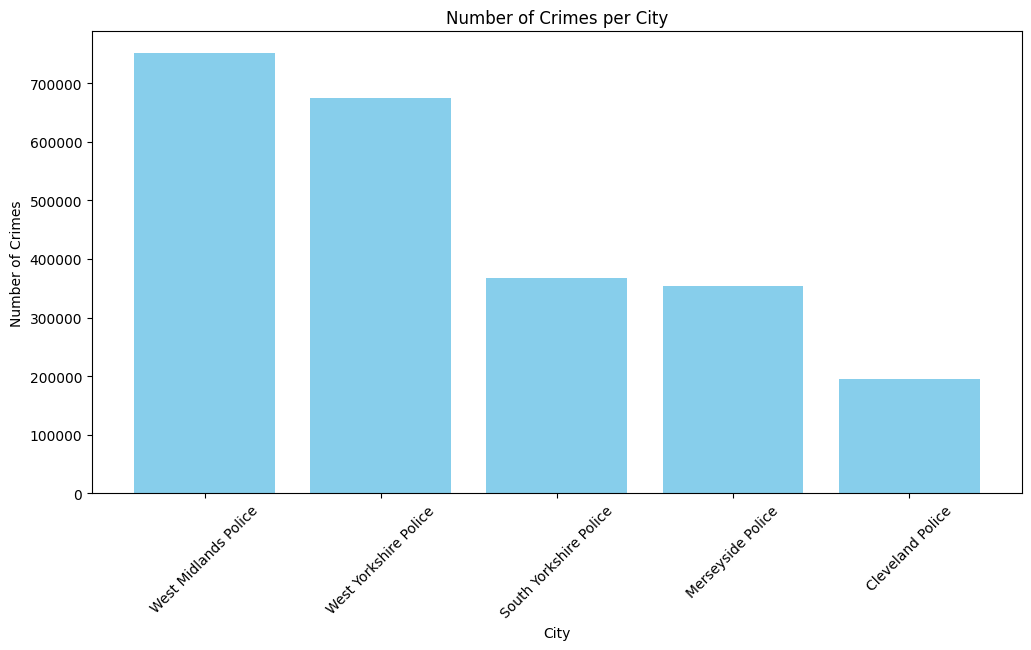

In [15]:
# Convert to Pandas DataFrame for visualization
crimes_per_city_pd = crimes_per_city.toPandas()

# Plot the data
plt.figure(figsize=(12, 6))
plt.bar(crimes_per_city_pd['City'], crimes_per_city_pd['CrimeCount'], color='skyblue')
plt.xlabel('City')
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes per City')
plt.xticks(rotation=45)
plt.show()


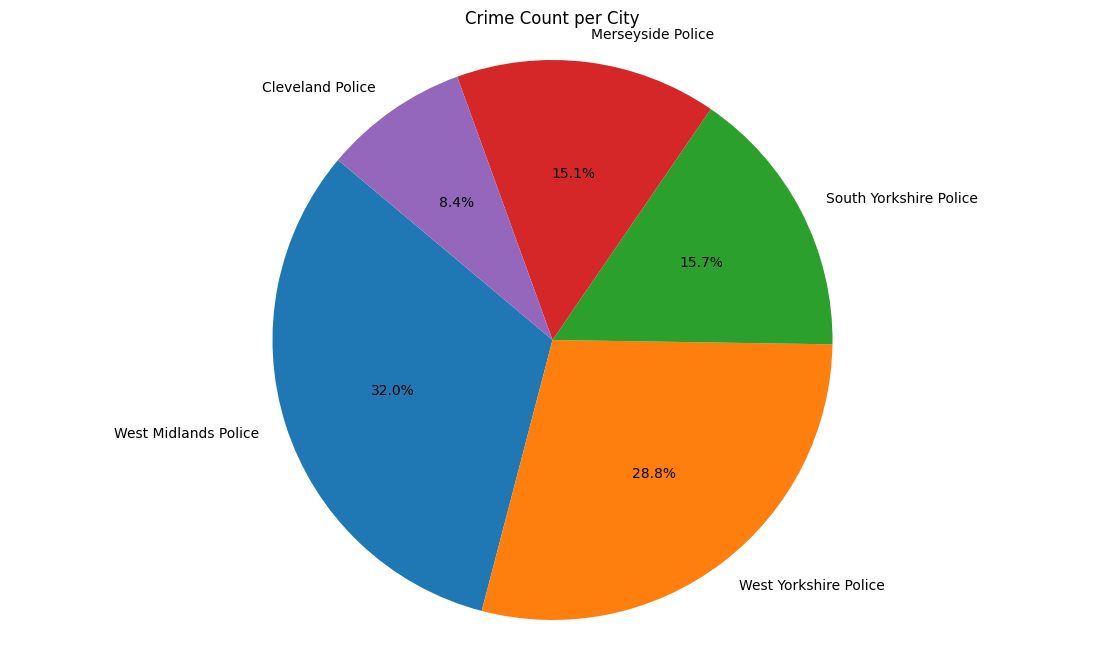

In [16]:
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for visualization
crimes_per_city_data = crimes_per_city.toPandas()

# Plot the data as a pie chart
plt.figure(figsize=(14, 8))
plt.pie(crimes_per_city_data['CrimeCount'], labels=crimes_per_city_data['City'], autopct='%1.1f%%', startangle=140)
plt.title('Crime Count per City')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()




In [17]:
#  Query 2: Most common crime type
common_crime_type = spark.sql("""
    SELECT `Crime_type`, COUNT(*) AS CrimeCount
    FROM DataCrime
    GROUP BY `Crime_type`
    ORDER BY CrimeCount DESC
""")
common_crime_type.show(10)


+--------------------+----------+
|          Crime_type|CrimeCount|
+--------------------+----------+
|Violence and sexu...|    922291|
|        Public order|    235397|
|Anti-social behav...|    216161|
|Criminal damage a...|    197264|
|       Vehicle crime|    156001|
|         Other theft|    149642|
|         Shoplifting|    133082|
|            Burglary|    115901|
|               Drugs|     70567|
|         Other crime|     50203|
+--------------------+----------+
only showing top 10 rows



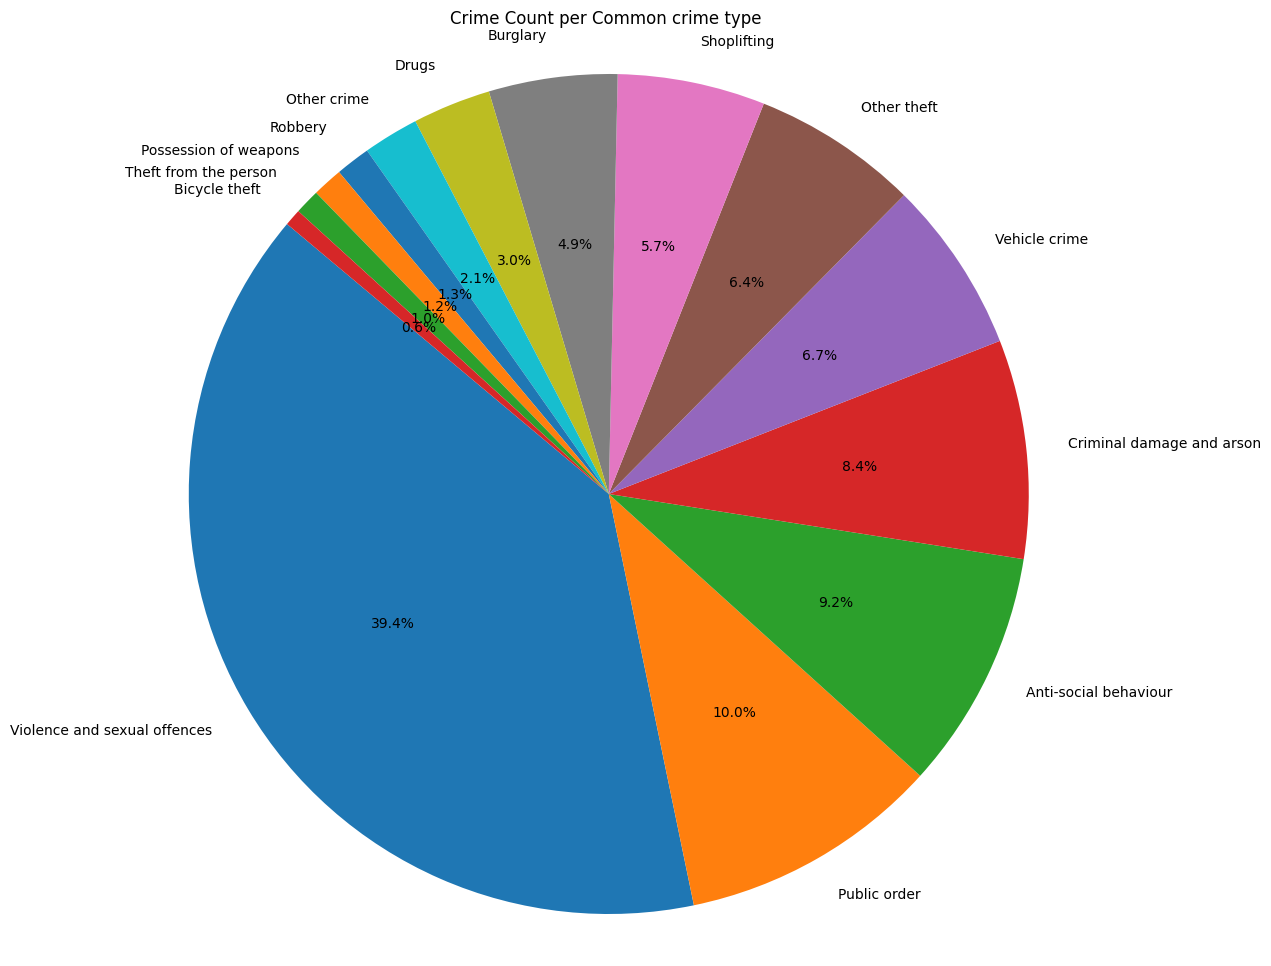

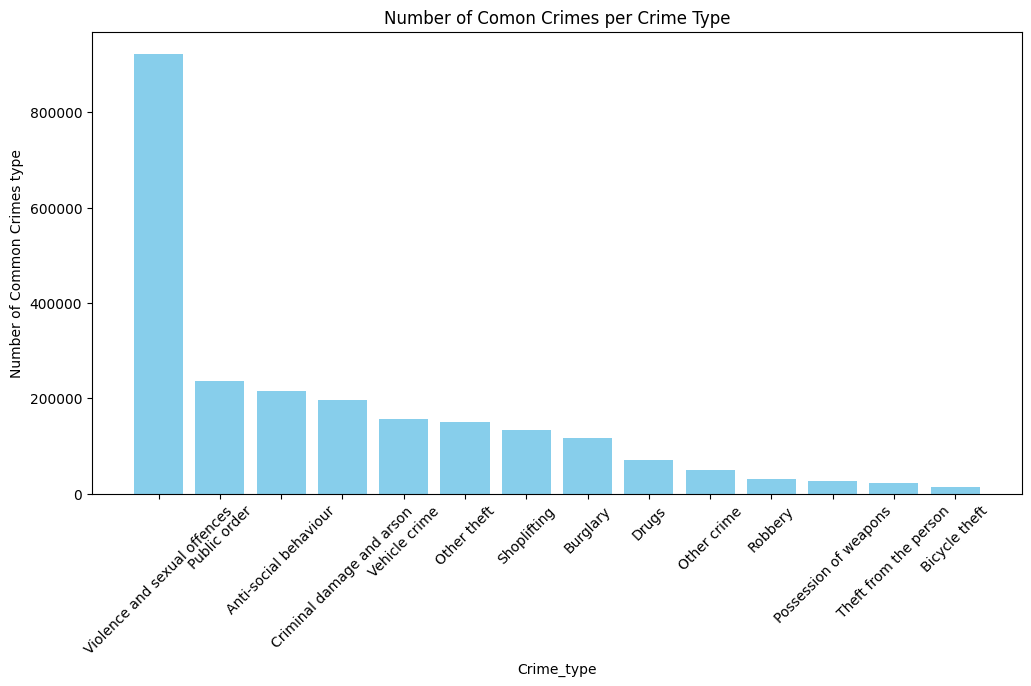

In [18]:
# Convert to Pandas DataFrame for visualization
common_crime_type_data = common_crime_type.toPandas()

# Plot the data as a pie chart
plt.figure(figsize=(14, 12))
plt.pie(common_crime_type_data['CrimeCount'], labels=common_crime_type_data['Crime_type'], autopct='%1.1f%%', startangle=140)
plt.title('Crime Count per Common crime type ')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()



# Plot the data
plt.figure(figsize=(12, 6))
plt.bar(common_crime_type_data['Crime_type'], common_crime_type_data['CrimeCount'], color='skyblue')
plt.xlabel('Crime_type')
plt.ylabel('Number of Common Crimes type')
plt.title('Number of Comon Crimes per Crime Type')
plt.xticks(rotation=45)
plt.show()

In [19]:
#Query 3: Monthly trends of crimes
monthly_trends = spark.sql("""
    SELECT YEAR(`Month`) AS Year, MONTH(`Month`) AS Month, COUNT(*) AS CrimeCount
    FROM DataCrime
    GROUP BY Year, Month
    ORDER BY Year, Month
""")
monthly_trends.show(10)



+----+-----+----------+
|Year|Month|CrimeCount|
+----+-----+----------+
|2022|    1|     94492|
|2022|    2|     89834|
|2022|    3|    102204|
|2022|    4|     99934|
|2022|    5|    108196|
|2022|    6|    102550|
|2022|    7|    106377|
|2022|    8|    106129|
|2022|    9|     99265|
|2022|   10|    103368|
+----+-----+----------+
only showing top 10 rows



+------------------+----------+
|         LSOA_name|CrimeCount|
+------------------+----------+
|              NULL|     25873|
|        Leeds 111B|     15729|
|   Birmingham 138A|     11105|
|    Liverpool 060C|     10592|
|    Liverpool 061C|      7398|
|    Sheffield 073D|      5756|
|   Birmingham 135C|      5510|
|     Coventry 031C|      5490|
|Middlesbrough 001A|      5180|
|    Doncaster 022E|      5084|
+------------------+----------+



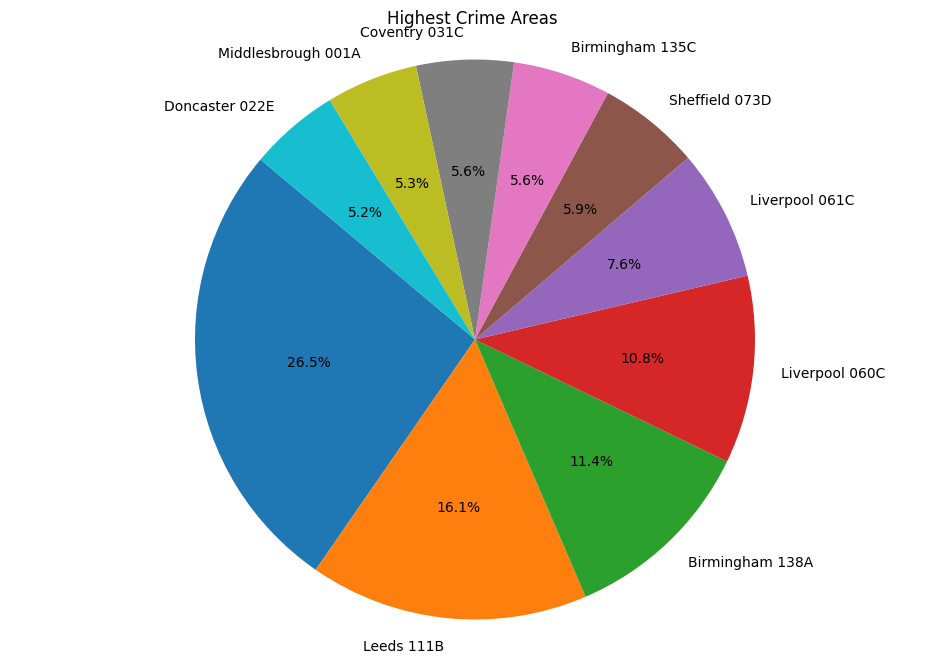

In [20]:
# Example Query 4: Highest crime areas
highest_crime_areas = spark.sql("""
    SELECT `LSOA_name`, COUNT(*) AS CrimeCount
    FROM DataCrime
    GROUP BY `LSOA_name`
    ORDER BY CrimeCount DESC
    LIMIT 10
""")
highest_crime_areas.show()

# Convert to Pandas DataFrame for visualization
highest_crime_areas_data = highest_crime_areas.toPandas()

# Plot the data as a pie chart
plt.figure(figsize=(12, 8))
plt.pie(highest_crime_areas_data['CrimeCount'], labels=highest_crime_areas_data['LSOA_name'], autopct='%1.1f%%', startangle=140)
plt.title('Highest Crime Areas ')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [21]:
# Query 5: Most reported crime type and "Falls within" by city
most_reported_crime = spark.sql("""
    SELECT `Crime_type`, `Falls_within` AS City, COUNT(*) AS CrimeCount
    FROM DataCrime
    GROUP BY `Crime_type`, `Falls_within`
    ORDER BY CrimeCount DESC
    LIMIT 10
""")
most_reported_crime.show()




+--------------------+--------------------+----------+
|          Crime_type|                City|CrimeCount|
+--------------------+--------------------+----------+
|Violence and sexu...|West Midlands Police|    312698|
|Violence and sexu...|West Yorkshire Po...|    279815|
|Violence and sexu...|   Merseyside Police|    140503|
|Violence and sexu...|South Yorkshire P...|    123745|
|        Public order|West Yorkshire Po...|     78810|
|       Vehicle crime|West Midlands Police|     72984|
|Violence and sexu...|    Cleveland Police|     65530|
|        Public order|West Midlands Police|     58852|
|Criminal damage a...|West Midlands Police|     57020|
|Criminal damage a...|West Yorkshire Po...|     55314|
+--------------------+--------------------+----------+



In [22]:
# Query 6: Average, Minimum, and Maximum crime counts per city
crime_statsti_per_city = spark.sql("""
    SELECT `Falls_within` AS City, 
           AVG(CrimeCount) AS AvgCrime, 
           MIN(CrimeCount) AS MinCrime, 
           MAX(CrimeCount) AS MaxCrime
    FROM (
        SELECT `Falls_within`, COUNT(*) AS CrimeCount
        FROM DataCrime
        GROUP BY `Falls_within`
    )
    GROUP BY City
    ORDER BY AvgCrime DESC
""")
crime_statsti_per_city.show(10)

+--------------------+--------+--------+--------+
|                City|AvgCrime|MinCrime|MaxCrime|
+--------------------+--------+--------+--------+
|West Midlands Police|750836.0|  750836|  750836|
|West Yorkshire Po...|675336.0|  675336|  675336|
|South Yorkshire P...|367416.0|  367416|  367416|
|   Merseyside Police|353676.0|  353676|  353676|
|    Cleveland Police|195940.0|  195940|  195940|
+--------------------+--------+--------+--------+



In [23]:
# Example Query 6: Average, Minimum, and Maximum crime counts per city
crime_statstic_per_city = spark.sql("""
    SELECT `Falls_within` AS City, 
           AVG(CrimeCount) AS AvgCrime, 
           MIN(CrimeCount) AS MinCrime, 
           MAX(CrimeCount) AS MaxCrime,
           MEAN(CrimeCount) AS MEANCrime,
           Variance(CrimeCount) AS VarianceCrime,
           stddev(CrimeCount) AS Standard_deviationCrime
    FROM (
        SELECT `Falls_within`, COUNT(*) AS CrimeCount
        FROM DataCrime
        GROUP BY `Falls_within`
    )
    GROUP BY City
    ORDER BY AvgCrime DESC
""")
crime_statstic_per_city.show(10)

+--------------------+--------+--------+--------+---------+-------------+-----------------------+
|                City|AvgCrime|MinCrime|MaxCrime|MEANCrime|VarianceCrime|Standard_deviationCrime|
+--------------------+--------+--------+--------+---------+-------------+-----------------------+
|West Midlands Police|750836.0|  750836|  750836| 750836.0|         NULL|                   NULL|
|West Yorkshire Po...|675336.0|  675336|  675336| 675336.0|         NULL|                   NULL|
|South Yorkshire P...|367416.0|  367416|  367416| 367416.0|         NULL|                   NULL|
|   Merseyside Police|353676.0|  353676|  353676| 353676.0|         NULL|                   NULL|
|    Cleveland Police|195940.0|  195940|  195940| 195940.0|         NULL|                   NULL|
+--------------------+--------+--------+--------+---------+-------------+-----------------------+



In [24]:
# Example Query 7: Yearly crime rate and type
yearly_crime_rate = spark.sql("""
    SELECT YEAR(`Month`) AS Year, `Crime_type`, COUNT(*) AS CrimeCount
    FROM DataCrime
    GROUP BY Year, `Crime_type`
    ORDER BY Year, CrimeCount DESC
""")
yearly_crime_rate.show()




+----+--------------------+----------+
|Year|          Crime_type|CrimeCount|
+----+--------------------+----------+
|2022|Violence and sexu...|    476945|
|2022|        Public order|    130738|
|2022|Anti-social behav...|    106676|
|2022|Criminal damage a...|    103215|
|2022|       Vehicle crime|     79564|
|2022|         Other theft|     76487|
|2022|            Burglary|     57941|
|2022|         Shoplifting|     57475|
|2022|               Drugs|     35439|
|2022|         Other crime|     24600|
|2022|             Robbery|     15194|
|2022|Possession of wea...|     13952|
|2022|Theft from the pe...|     12093|
|2022|       Bicycle theft|      8111|
|2023|Violence and sexu...|    445346|
|2023|Anti-social behav...|    109485|
|2023|        Public order|    104659|
|2023|Criminal damage a...|     94049|
|2023|       Vehicle crime|     76437|
|2023|         Shoplifting|     75607|
+----+--------------------+----------+
only showing top 20 rows



In [25]:
# Query 8: Quarterly crime rate and location
quarterly_crime_rate = spark.sql("""
    SELECT QUARTER(`Month`) AS Quarter, YEAR(`Month`) AS Year, `Falls_within` AS City, COUNT(*) AS CrimeCount
    FROM DataCrime
    GROUP BY Year, Quarter, City
    ORDER BY Year, Quarter, CrimeCount DESC
""")
quarterly_crime_rate.show()

+-------+----+--------------------+----------+
|Quarter|Year|                City|CrimeCount|
+-------+----+--------------------+----------+
|      1|2022|West Midlands Police|     93677|
|      1|2022|West Yorkshire Po...|     81066|
|      1|2022|   Merseyside Police|     45669|
|      1|2022|South Yorkshire P...|     43710|
|      1|2022|    Cleveland Police|     22408|
|      2|2022|West Midlands Police|     99282|
|      2|2022|West Yorkshire Po...|     89141|
|      2|2022|   Merseyside Police|     48671|
|      2|2022|South Yorkshire P...|     47776|
|      2|2022|    Cleveland Police|     25810|
|      3|2022|West Midlands Police|     99954|
|      3|2022|West Yorkshire Po...|     90557|
|      3|2022|   Merseyside Police|     47671|
|      3|2022|South Yorkshire P...|     47513|
|      3|2022|    Cleveland Police|     26076|
|      4|2022|West Midlands Police|     93265|
|      4|2022|West Yorkshire Po...|     81614|
|      4|2022|South Yorkshire P...|     45571|
|      4|2022

<ipython-input-26-56a1993a3cd3>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=quarterly_crime_rate_Datacrime, x='Quarter', y='CrimeCount', hue='Year', ci=None)


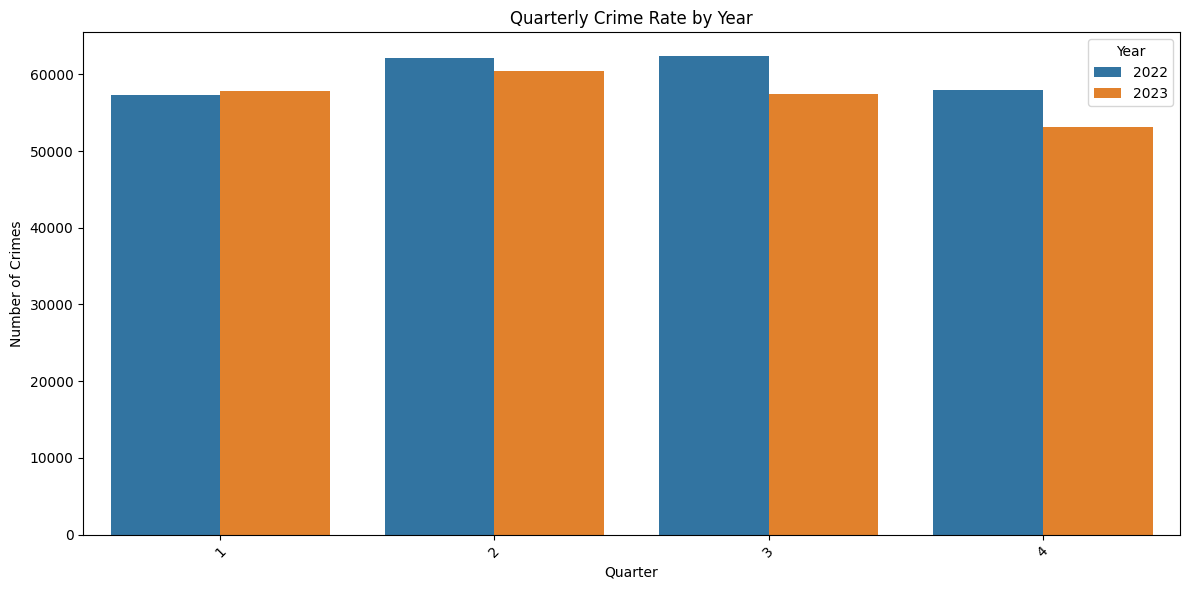

In [26]:

# Convert Spark DataFrame to Pandas DataFrame
quarterly_crime_rate_Datacrime = quarterly_crime_rate.toPandas()

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a bar plot
sns.barplot(data=quarterly_crime_rate_Datacrime, x='Quarter', y='CrimeCount', hue='Year', ci=None)

# Add titles and labels
plt.title('Quarterly Crime Rate by Year')
plt.xlabel('Quarter')
plt.ylabel('Number of Crimes')
plt.legend(title='Year')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

In [27]:
# Filter data for the year 2022
DataCrime_2022 = DataCrime.filter((col("Month") >= '2022-01-01') & (col("Month") <= '2022-12-31'))
DataCrime_2022.createOrReplaceTempView("DataCrime_2022")

# Show the schema of the dataset
DataCrime_2022.printSchema()


root
 |-- Crime_ID: string (nullable = true)
 |-- Month: timestamp (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Context: string (nullable = true)



+--------------------+----------+
|                City|CrimeCount|
+--------------------+----------+
|West Midlands Police|    386178|
|West Yorkshire Po...|    342378|
|   Merseyside Police|    186473|
|South Yorkshire P...|    184570|
|    Cleveland Police|     98831|
+--------------------+----------+



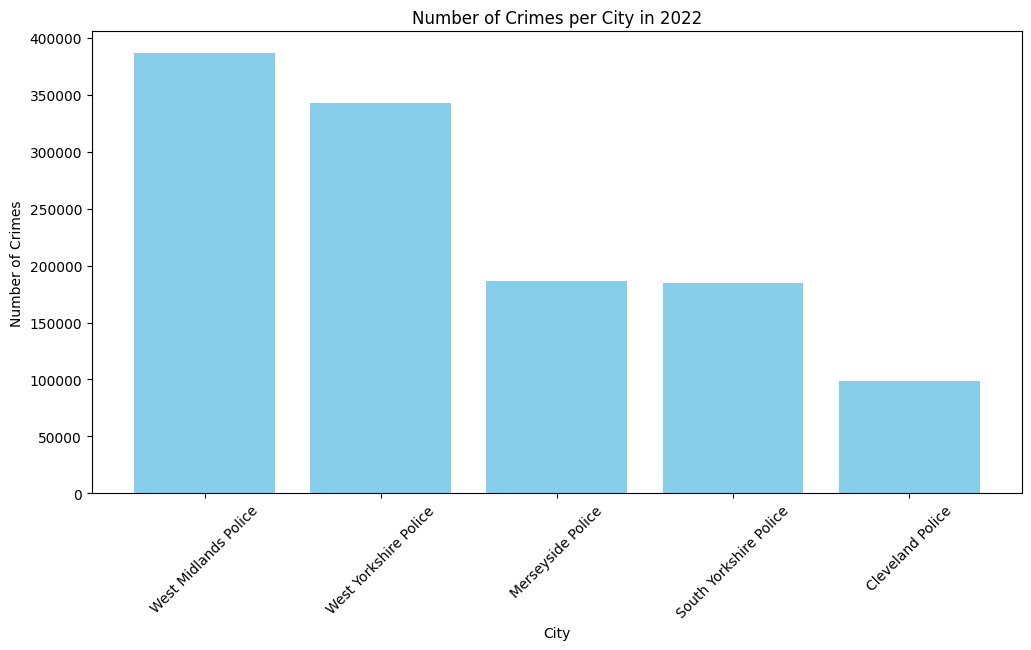

In [28]:

# Example Query 1: Count crimes per city in 2022
crimes_per_city_2022 = spark.sql("""
    SELECT `Falls_within` AS City, COUNT(*) AS CrimeCount
    FROM DataCrime_2022
    GROUP BY `Falls_within`
    ORDER BY CrimeCount DESC
""")
crimes_per_city_2022.show(10)

# Convert to Pandas DataFrame for visualization
crimes_per_city_2022_data = crimes_per_city_2022.toPandas()

# Plot the data
plt.figure(figsize=(12, 6))
plt.bar(crimes_per_city_2022_data['City'], crimes_per_city_2022_data['CrimeCount'], color='skyblue')
plt.xlabel('City')
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes per City in 2022')
plt.xticks(rotation=45)
plt.show()


+--------------------+----------+
|          Crime_type|CrimeCount|
+--------------------+----------+
|Violence and sexu...|    476945|
|        Public order|    130738|
|Anti-social behav...|    106676|
|Criminal damage a...|    103215|
|       Vehicle crime|     79564|
|         Other theft|     76487|
|            Burglary|     57941|
|         Shoplifting|     57475|
|               Drugs|     35439|
|         Other crime|     24600|
+--------------------+----------+
only showing top 10 rows



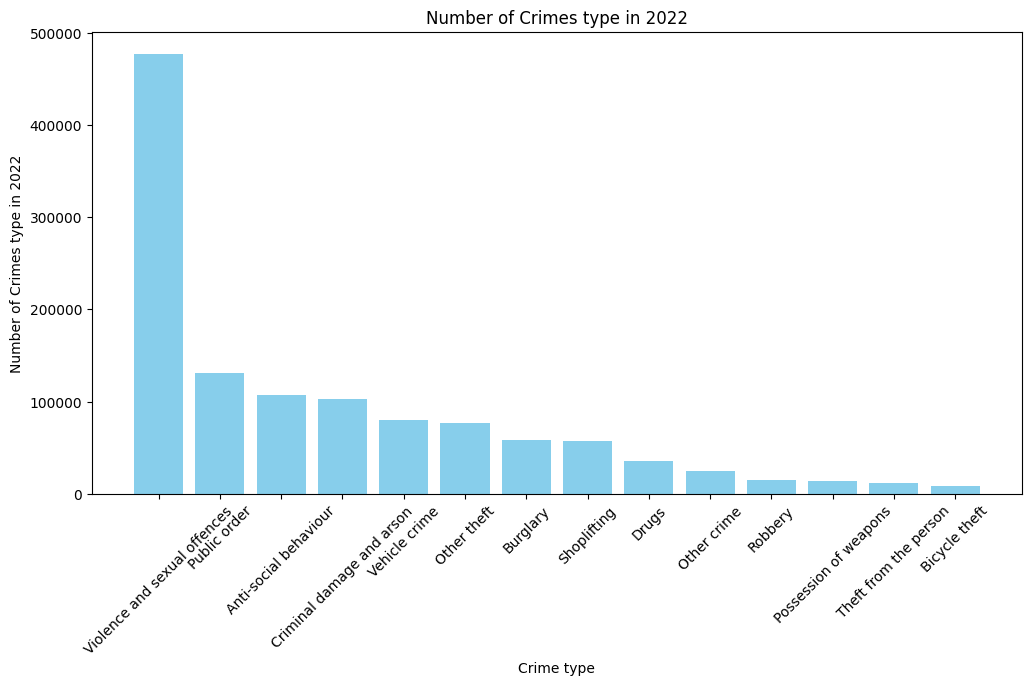

In [29]:
# Example Query 2: Most common crime type in 2022
common_crime_type_2022 = spark.sql("""
    SELECT `Crime_type`, COUNT(*) AS CrimeCount
    FROM DataCrime_2022
    GROUP BY `Crime_type`
    ORDER BY CrimeCount DESC
""")
common_crime_type_2022.show(10)

# Convert to Pandas DataFrame for visualization
common_crime_type_2022_data = common_crime_type_2022.toPandas()

# Plot the data
plt.figure(figsize=(12, 6))
plt.bar(common_crime_type_2022_data['Crime_type'], common_crime_type_2022_data['CrimeCount'], color='skyblue')
plt.xlabel('Crime type')
plt.ylabel('Number of Crimes type in 2022')
plt.title('Number of Crimes type in 2022')
plt.xticks(rotation=45)
plt.show()



In [30]:
# Example Query 3: Monthly trends of crimes in 2022
monthly_trends_2022 = spark.sql("""
    SELECT YEAR(`Month`) AS Year, MONTH(`Month`) AS Month, COUNT(*) AS CrimeCount
    FROM DataCrime_2022
    GROUP BY Year, Month
    ORDER BY Year, Month
""")
monthly_trends_2022.show(12)




+----+-----+----------+
|Year|Month|CrimeCount|
+----+-----+----------+
|2022|    1|     94492|
|2022|    2|     89834|
|2022|    3|    102204|
|2022|    4|     99934|
|2022|    5|    108196|
|2022|    6|    102550|
|2022|    7|    106377|
|2022|    8|    106129|
|2022|    9|     99265|
|2022|   10|    103368|
|2022|   11|     96637|
|2022|   12|     89444|
+----+-----+----------+



In [31]:
# Example Query 4: Highest crime areas in 2022
highest_crime_areas_2022 = spark.sql("""
    SELECT `LSOA_name`, COUNT(*) AS CrimeCount
    FROM DataCrime_2022
    GROUP BY `LSOA_name`
    ORDER BY CrimeCount DESC
    LIMIT 10
""")
highest_crime_areas_2022.show()



+------------------+----------+
|         LSOA_name|CrimeCount|
+------------------+----------+
|              NULL|     13622|
|        Leeds 111B|      7531|
|   Birmingham 138A|      5762|
|    Liverpool 060C|      5067|
|    Liverpool 061C|      4521|
|     Coventry 031C|      4063|
|    Doncaster 022E|      3708|
|     Bradford 039G|      3649|
|Wolverhampton 020F|      3499|
|Middlesbrough 001G|      3348|
+------------------+----------+



+--------------------+----------+
|          Crime_type|CrimeCount|
+--------------------+----------+
|Violence and sexu...|    476945|
|        Public order|    130738|
|Anti-social behav...|    106676|
|Criminal damage a...|    103215|
|       Vehicle crime|     79564|
|         Other theft|     76487|
|            Burglary|     57941|
|         Shoplifting|     57475|
|               Drugs|     35439|
|         Other crime|     24600|
|             Robbery|     15194|
|Possession of wea...|     13952|
|Theft from the pe...|     12093|
|       Bicycle theft|      8111|
+--------------------+----------+



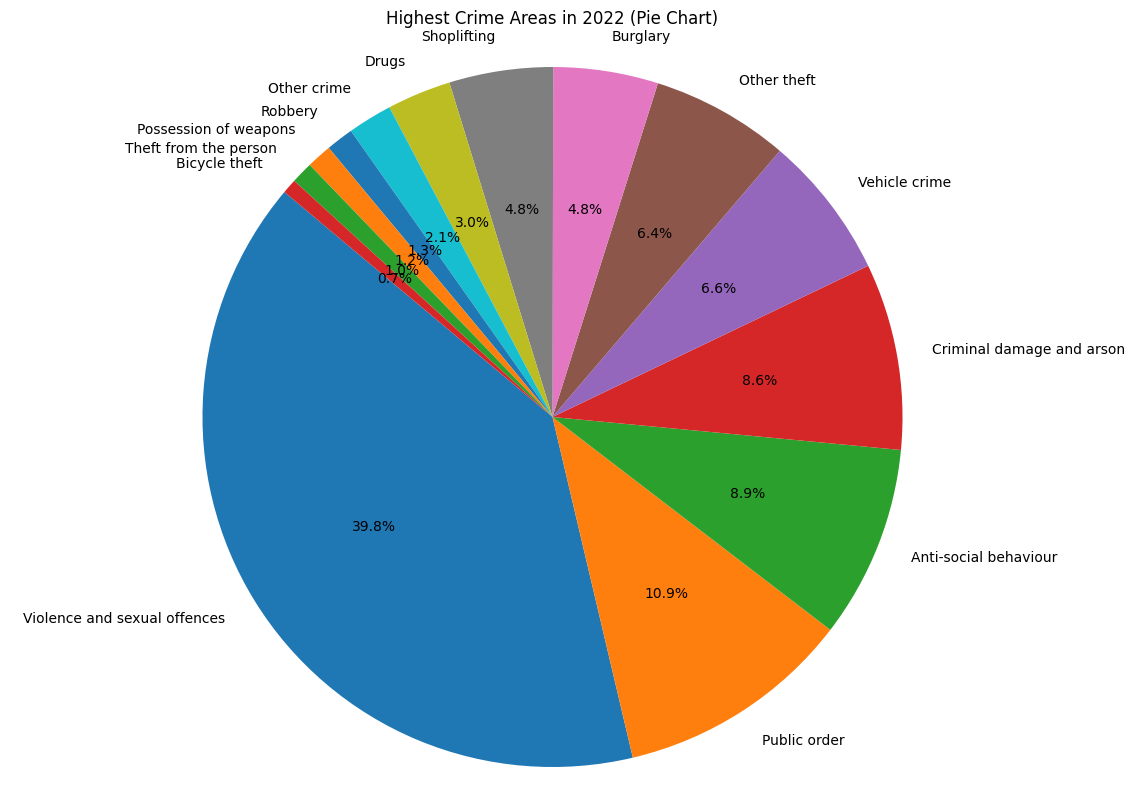

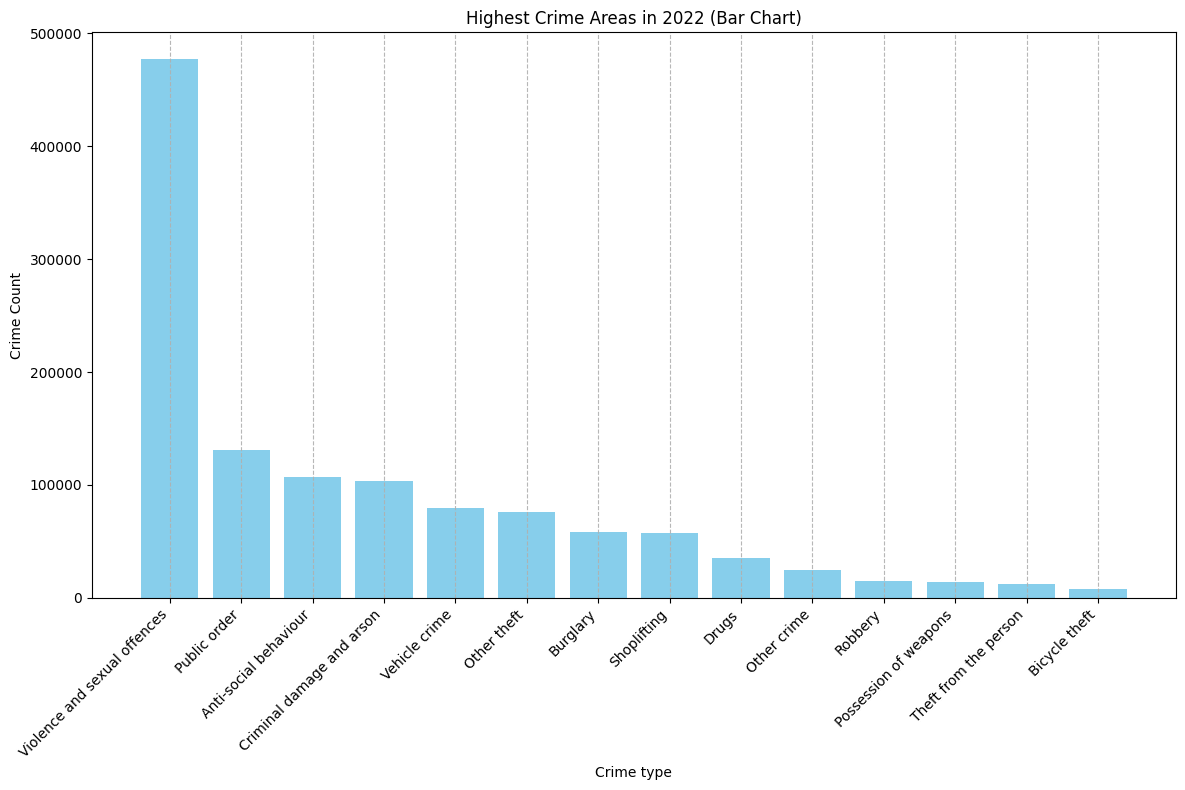

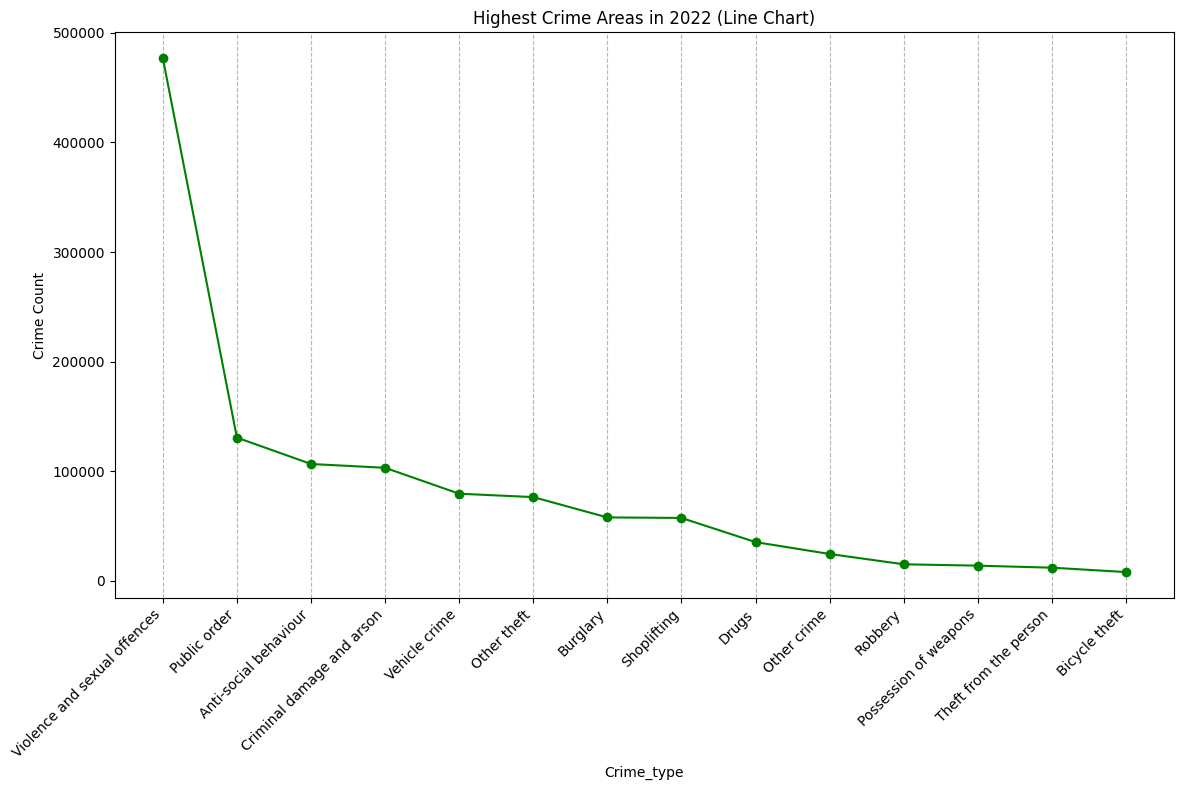

In [32]:
# Query: Yearly crime rate and type for 2022
yearly_crime_rate_2022 = spark.sql("""
    SELECT `Crime_type`, COUNT(*) AS CrimeCount
    FROM DataCrime_2022
    GROUP BY `Crime_type`
    ORDER BY CrimeCount DESC
""")
yearly_crime_rate_2022.show(20)


# Convert Spark DataFrame to Pandas for visualization
yearly_crime_rate_2022_datacrime = yearly_crime_rate_2022.toPandas()

# Handle missing values (e.g., drop rows with missing values)
yearly_crime_rate_2022_datacrime.dropna(inplace=True)

# Pie chart 
plt.figure(figsize=(14, 10)) 
plt.pie(yearly_crime_rate_2022_datacrime['CrimeCount'], labels=yearly_crime_rate_2022_datacrime['Crime_type'], autopct='%1.1f%%', startangle=140) 
plt.title('Highest Crime Areas in 2022 (Pie Chart)') 
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle. 
plt.show()

# Bar chart
plt.figure(figsize=(12, 8))
plt.bar(yearly_crime_rate_2022_datacrime['Crime_type'], yearly_crime_rate_2022_datacrime['CrimeCount'], color='skyblue')
plt.title('Highest Crime Areas in 2022 (Bar Chart)')
plt.xlabel('Crime type')
plt.ylabel('Crime Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x', linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

# Line chart
plt.figure(figsize=(12, 8))
plt.plot(yearly_crime_rate_2022_datacrime['Crime_type'], yearly_crime_rate_2022_datacrime['CrimeCount'], marker='o', linestyle='-', color='green')
plt.title('Highest Crime Areas in 2022 (Line Chart)')
plt.xlabel('Crime_type')
plt.ylabel('Crime Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x', linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()


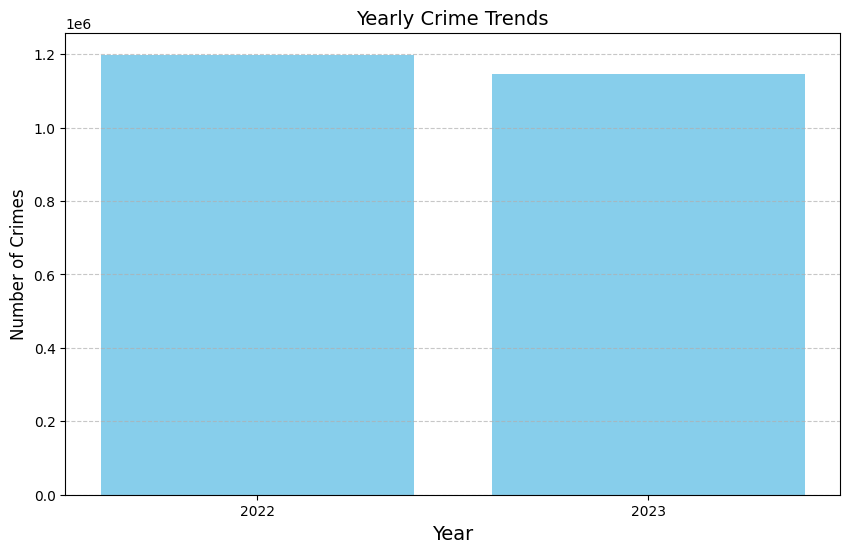

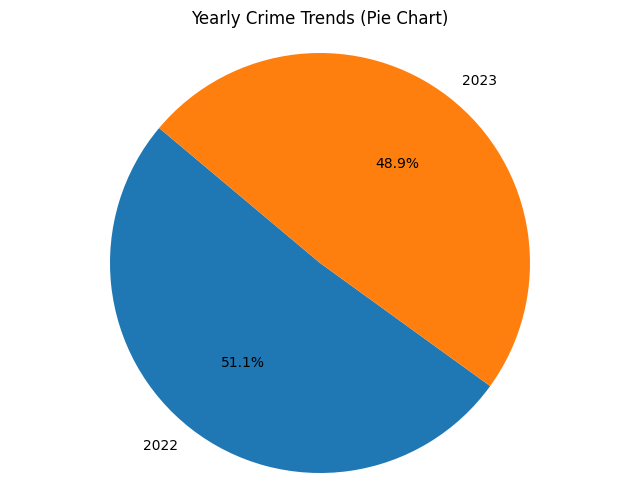

In [33]:
# Query: Rate Yearly crime trends 
yearly_crime_trends = spark.sql("""
    SELECT YEAR(`Month`) AS Year, COUNT(*) AS CrimeCount
    FROM DataCrime
    GROUP BY Year
    ORDER BY Year
""")

# Convert Spark DataFrame to Pandas for visualization
yearly_crime_trends_datacrime = yearly_crime_trends.toPandas()

# Plot Yearly Trends
plt.figure(figsize=(10, 6))
plt.bar(yearly_crime_trends_datacrime['Year'], yearly_crime_trends_datacrime['CrimeCount'], color='skyblue')
plt.title("Yearly Crime Trends", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Crimes", fontsize=12)
plt.xticks(yearly_crime_trends_datacrime['Year'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Pie chart 
plt.figure(figsize=(8, 6)) 
plt.pie(yearly_crime_trends_datacrime['CrimeCount'], labels=yearly_crime_trends_datacrime['Year'], autopct='%1.1f%%', startangle=140) 
plt.title('Yearly Crime Trends (Pie Chart)') 
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle. 
plt.show()

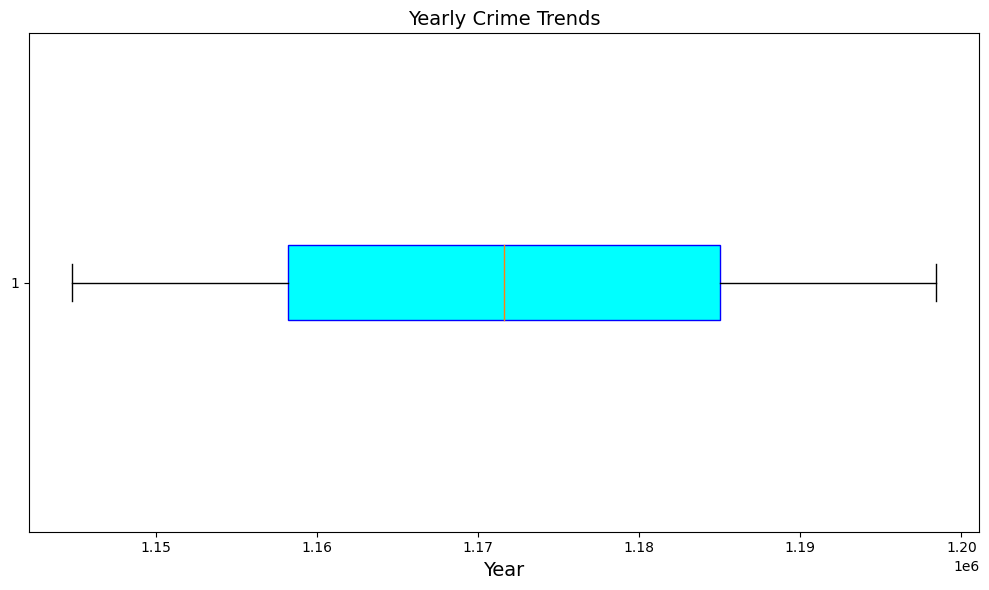

In [34]:


# Example Query: Rate Yearly crime trends 
yearly_crime_trends = spark.sql("""
    SELECT YEAR(`Month`) AS Year, COUNT(*) AS CrimeCount
    FROM DataCrime
    GROUP BY Year
    ORDER BY Year
""")
# Convert Spark DataFrame to Pandas for visualization
yearly_crime_trends_datacrime = yearly_crime_trends.toPandas()

# Plot Yearly Trends
plt.figure(figsize=(10, 6))
plt.boxplot(yearly_crime_trends_datacrime['CrimeCount'], vert=False, patch_artist=True, boxprops=dict(facecolor='cyan', color='blue'))
plt.title("Yearly Crime Trends", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.tight_layout()
plt.show()

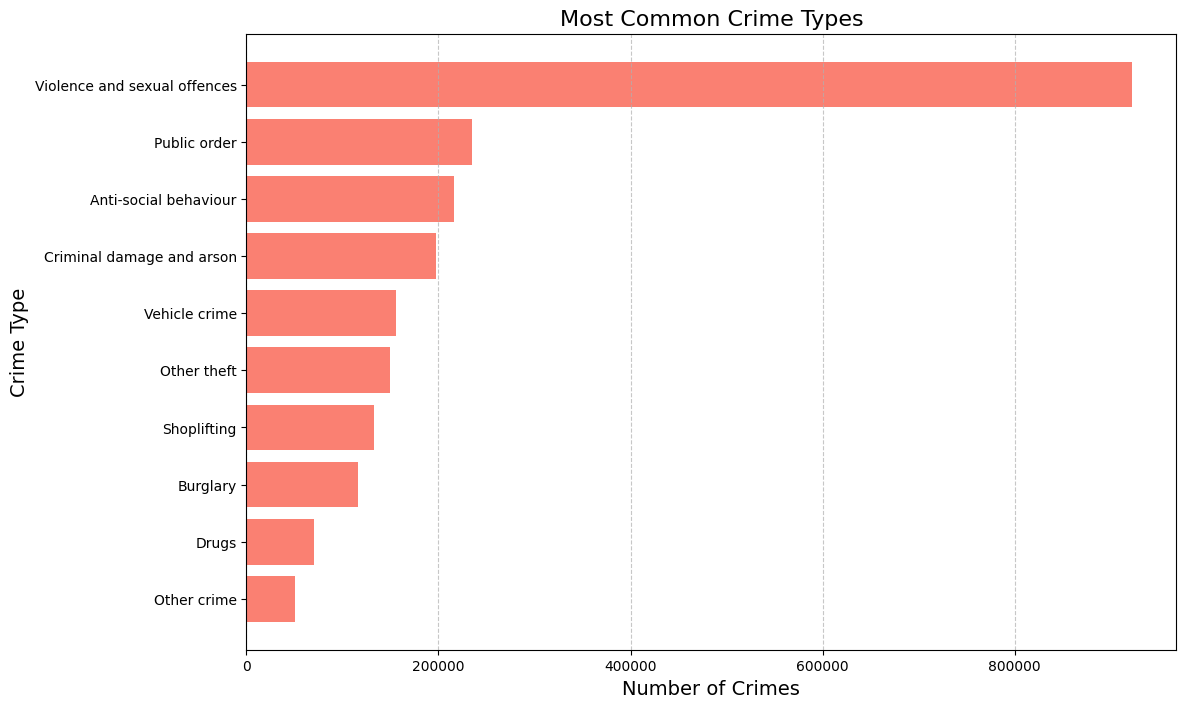

In [35]:
# Example Query: Most common crime types
common_crime_types = spark.sql("""
    SELECT `Crime_type`, COUNT(*) AS CrimeCount
    FROM DataCrime
    GROUP BY `Crime_type`
    ORDER BY CrimeCount DESC
    LIMIT 10
""")

# Convert Spark DataFrame to Pandas for visualization
common_crime_types_datacrime = common_crime_types.toPandas()

# Plot Most Common Crime Types
plt.figure(figsize=(12, 8))
plt.barh(common_crime_types_datacrime['Crime_type'], common_crime_types_datacrime['CrimeCount'], color='salmon')
plt.title("Most Common Crime Types", fontsize=16)
plt.xlabel("Number of Crimes", fontsize=14)
plt.ylabel("Crime Type", fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

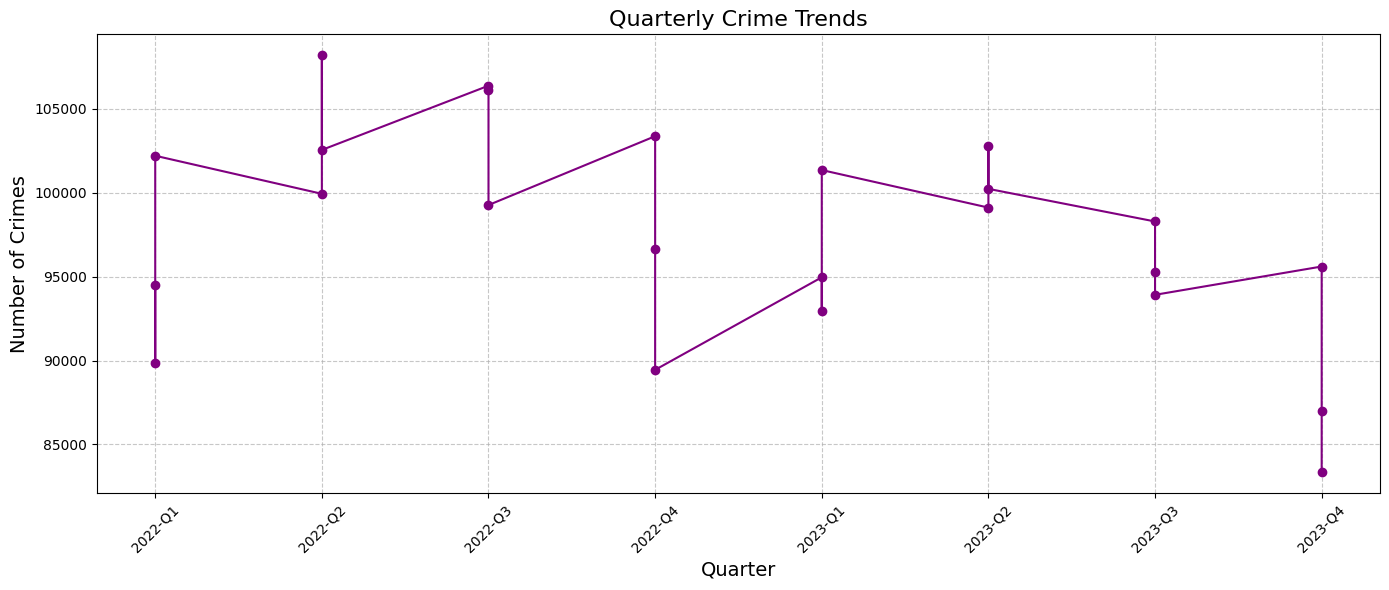

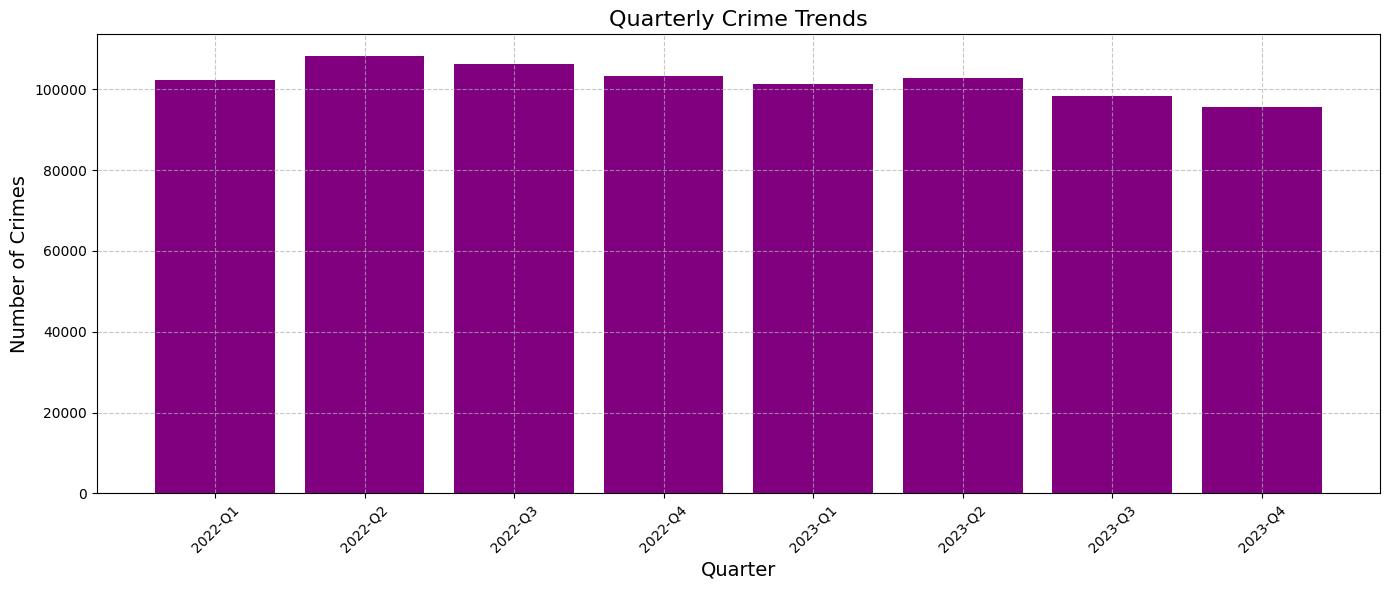

In [36]:
# Example Query: Quarterly crime trends
quarterly_trends = spark.sql("""
    SELECT CONCAT(YEAR(`Month`), '-Q', QUARTER(`Month`)) AS Quarter, COUNT(*) AS CrimeCount
    FROM DataCrime
    GROUP BY month, Quarter
    ORDER BY month, Quarter
""")

# Convert Spark DataFrame to Pandas for visualization
quarterly_trends_datacrime = quarterly_trends.toPandas()

# Plot Quarterly Trends
plt.figure(figsize=(14, 6))
plt.plot(quarterly_trends_datacrime['Quarter'], quarterly_trends_datacrime['CrimeCount'], marker='o', color='purple', linestyle='-')
plt.title("Quarterly Crime Trends", fontsize=16)
plt.xlabel("Quarter", fontsize=14)
plt.ylabel("Number of Crimes", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Plot Quarterly Trends
plt.figure(figsize=(14, 6))
plt.bar(quarterly_trends_datacrime['Quarter'], quarterly_trends_datacrime['CrimeCount'], color='purple')
plt.title("Quarterly Crime Trends", fontsize=16)
plt.xlabel("Quarter", fontsize=14)
plt.ylabel("Number of Crimes", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [37]:
yearly_crime_trends = spark.sql("""
    SELECT YEAR(CAST(`Month` AS DATE)) AS Year, COUNT(*) AS CrimeCount
    FROM DataCrime
    GROUP BY YEAR(CAST(`Month` AS DATE))
    ORDER BY Year
""")
yearly_crime_trends.show(10)

+----+----------+
|Year|CrimeCount|
+----+----------+
|2022|   1198430|
|2023|   1144774|
+----+----------+



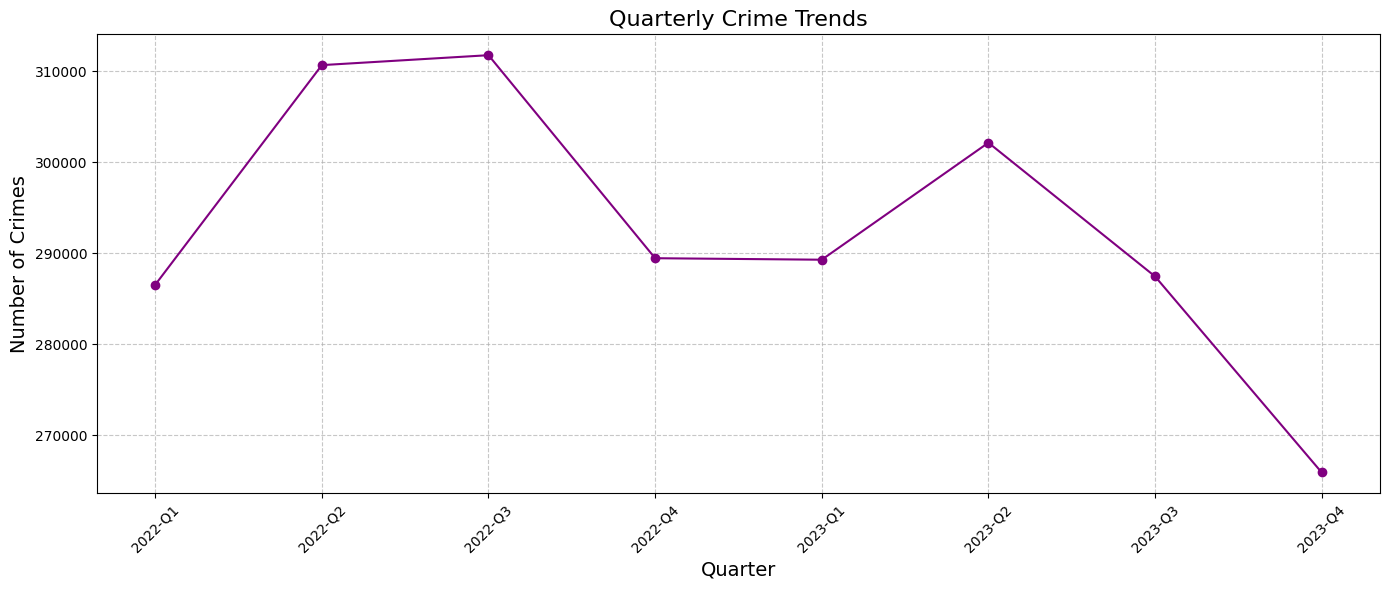

In [38]:
quarterly_trends_crime = spark.sql("""
    SELECT CONCAT(YEAR(CAST(`Month` AS DATE)), '-Q', QUARTER(CAST(`Month` AS DATE))) AS Quarter, 
           COUNT(*) AS CrimeCount
    FROM DataCrime
    GROUP BY YEAR(CAST(`Month` AS DATE)), QUARTER(CAST(`Month` AS DATE))
    ORDER BY YEAR(CAST(`Month` AS DATE)), QUARTER(CAST(`Month` AS DATE))
""")

# Convert Spark DataFrame to Pandas for visualization
quarterly_trends_datacrim = quarterly_trends_crime.toPandas()

# Plot Quarterly Trends
plt.figure(figsize=(14, 6))
plt.plot(quarterly_trends_datacrim['Quarter'], quarterly_trends_datacrim['CrimeCount'], marker='o', color='purple', linestyle='-')
plt.title("Quarterly Crime Trends", fontsize=16)
plt.xlabel("Quarter", fontsize=14)
plt.ylabel("Number of Crimes", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

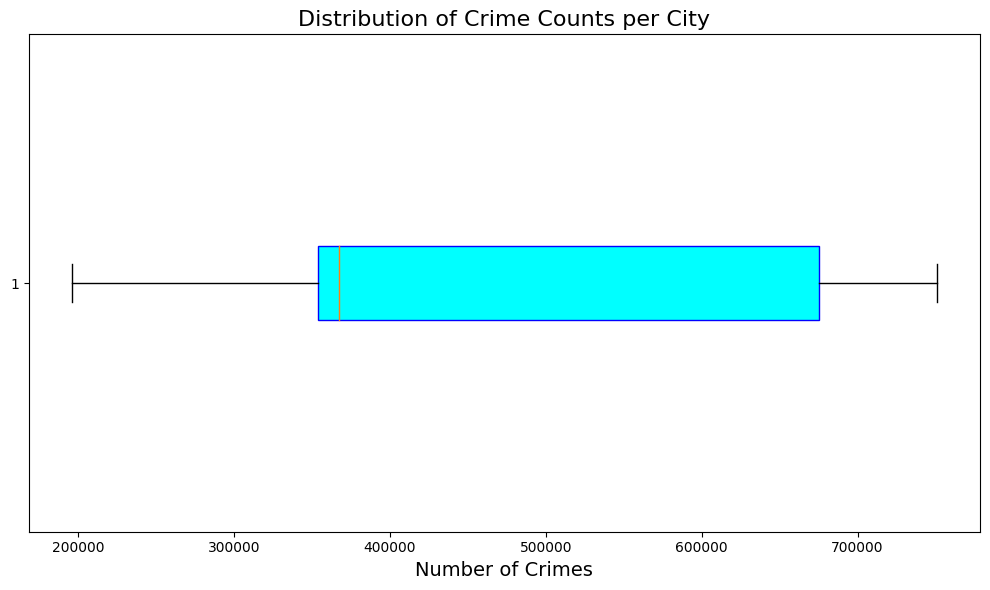

In [39]:
# Query: Crime counts per city
crime_counts_city = spark.sql("""
    SELECT `Falls_within` AS City, COUNT(*) AS CrimeCount
    FROM DataCrime
    GROUP BY `Falls_within`
    ORDER BY CrimeCount DESC
""")
crime_counts_city_datacrime = crime_counts_city.toPandas()

# Box Plot: Distribution of Crime Counts per City
plt.figure(figsize=(10, 6))
plt.boxplot(crime_counts_city_datacrime['CrimeCount'], vert=False, patch_artist=True, boxprops=dict(facecolor='cyan', color='blue'))
plt.title("Distribution of Crime Counts per City", fontsize=16)
plt.xlabel("Number of Crimes", fontsize=14)
plt.tight_layout()
plt.show()

In [40]:
# Filter data for the year 2022
DataCrime_2023 = DataCrime.filter((col("Month") >= '2023-01-01') & (col("Month") <= '2023-12-31'))
DataCrime_2023.createOrReplaceTempView("DataCrime_2023")

# Show the schema of the dataset
DataCrime_2023.printSchema()


root
 |-- Crime_ID: string (nullable = true)
 |-- Month: timestamp (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Context: string (nullable = true)



In [41]:
# Example Query 1: Count crimes per city in 2022
crimes_per_city_2023 = spark.sql("""
    SELECT `Falls_within` AS City, COUNT(*) AS CrimeCount
    FROM DataCrime_2023
    GROUP BY `Falls_within`
    ORDER BY CrimeCount DESC
""")
crimes_per_city_2023.show(10)



+--------------------+----------+
|                City|CrimeCount|
+--------------------+----------+
|West Midlands Police|    364658|
|West Yorkshire Po...|    332958|
|South Yorkshire P...|    182846|
|   Merseyside Police|    167203|
|    Cleveland Police|     97109|
+--------------------+----------+



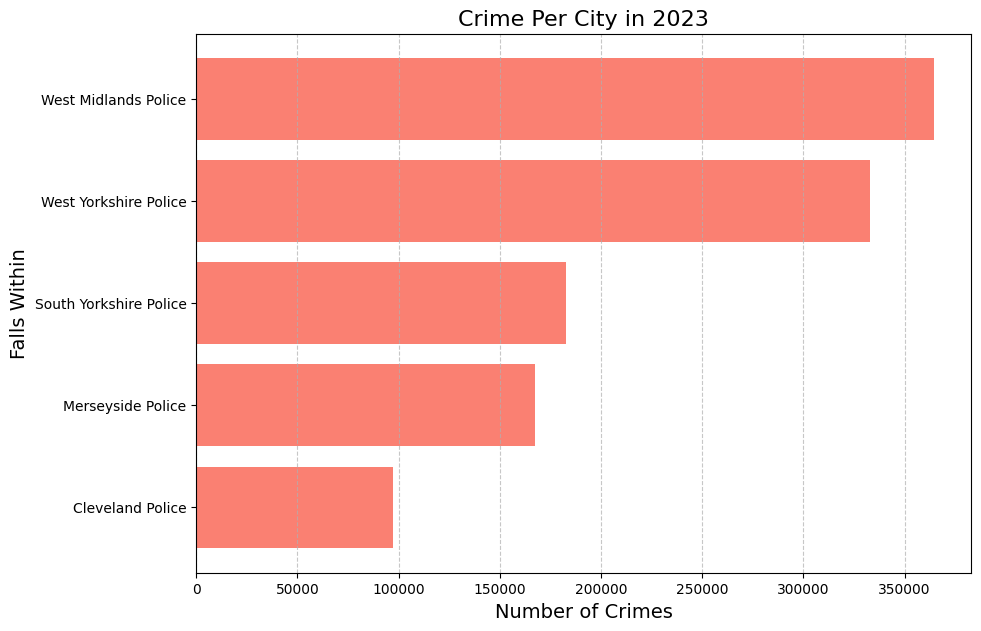

In [42]:
crimes_per_city_2023 = spark.sql("""
    SELECT `Falls_within`, COUNT(*) AS CrimeCount
    FROM DataCrime_2023
    GROUP BY `Falls_within`
    ORDER BY CrimeCount DESC
     """)
# Convert Spark DataFrame to Pandas for visualization
crimes_per_city_2023_datacrime = crimes_per_city_2023.toPandas()

# Plot The Crime per City in 2023
plt.figure(figsize=(10, 7))
plt.barh(crimes_per_city_2023_datacrime['Falls_within'], crimes_per_city_2023_datacrime['CrimeCount'], color='salmon')
plt.title("Crime Per City in 2023", fontsize=16)
plt.xlabel("Number of Crimes", fontsize=14)
plt.ylabel("Falls Within", fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [43]:
# Example Query 2: Most common crime type in 2022
common_crime_type_2023 = spark.sql("""
    SELECT `Crime_type`, COUNT(*) AS CrimeCount
    FROM Datacrime_2023
    GROUP BY `Crime_type`
    ORDER BY CrimeCount DESC
""")
common_crime_type_2023.show(20)


+--------------------+----------+
|          Crime_type|CrimeCount|
+--------------------+----------+
|Violence and sexu...|    445346|
|Anti-social behav...|    109485|
|        Public order|    104659|
|Criminal damage a...|     94049|
|       Vehicle crime|     76437|
|         Shoplifting|     75607|
|         Other theft|     73155|
|            Burglary|     57960|
|               Drugs|     35128|
|         Other crime|     25603|
|             Robbery|     16164|
|Possession of wea...|     13483|
|Theft from the pe...|     10632|
|       Bicycle theft|      7066|
+--------------------+----------+



+----+-----+----------+
|Year|Month|CrimeCount|
+----+-----+----------+
|2023|    1|     94959|
|2023|    2|     92974|
|2023|    3|    101351|
|2023|    4|     99113|
|2023|    5|    102805|
|2023|    6|    100230|
|2023|    7|     98286|
|2023|    8|     95247|
|2023|    9|     93915|
|2023|   10|     95602|
|2023|   11|     86963|
|2023|   12|     83329|
+----+-----+----------+



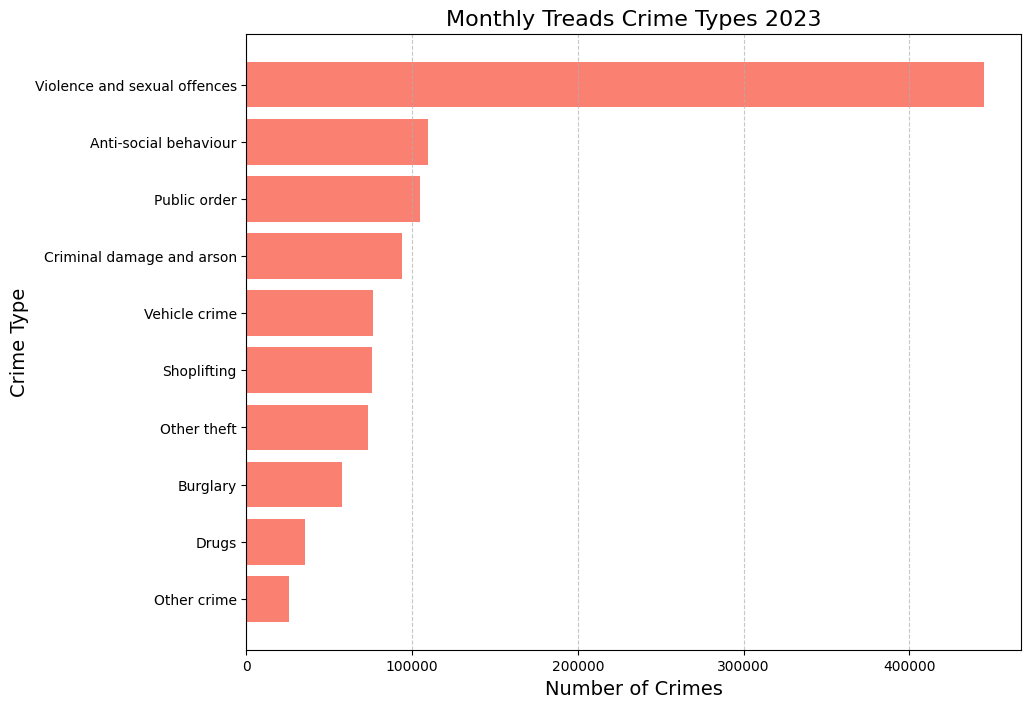

In [44]:

# Data Query 3: Monthly trends of crimes in 2023
monthly_rate_trends_2023 = spark.sql("""
    SELECT YEAR(`Month`) AS Year, MONTH(`Month`) AS Month, COUNT(*) AS CrimeCount
    FROM DataCrime_2023
    GROUP BY Year, Month
    ORDER BY Year, Month
""")
monthly_rate_trends_2023.show(12)

# Data Query: Most common crime types
monthly_rate_trends_2023 = spark.sql("""
    SELECT `Crime_type`, COUNT(*) AS CrimeCount
    FROM Datacrime_2023
    GROUP BY `Crime_type`
    ORDER BY CrimeCount DESC
    LIMIT 10
""")

# Convert Spark DataFrame to Pandas for visualization
monthly_rate_trends_2023_datacrime = monthly_rate_trends_2023.toPandas()

# Plot Most Common Crime Types
plt.figure(figsize=(10, 8))
plt.barh(monthly_rate_trends_2023_datacrime['Crime_type'], monthly_rate_trends_2023_datacrime['CrimeCount'], color='salmon')
plt.title("Monthly Treads Crime Types 2023", fontsize=16)
plt.xlabel("Number of Crimes", fontsize=14)
plt.ylabel("Crime Type", fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


+------------------+----------+
|         LSOA_name|CrimeCount|
+------------------+----------+
|              NULL|     12251|
|        Leeds 111B|      8198|
|    Liverpool 060C|      5525|
|   Birmingham 138A|      5343|
|    Sheffield 073D|      3048|
|    Liverpool 061C|      2877|
|     Kirklees 029D|      2671|
|   Birmingham 135C|      2446|
|Middlesbrough 001A|      2426|
|     Bradford 065C|      2406|
+------------------+----------+



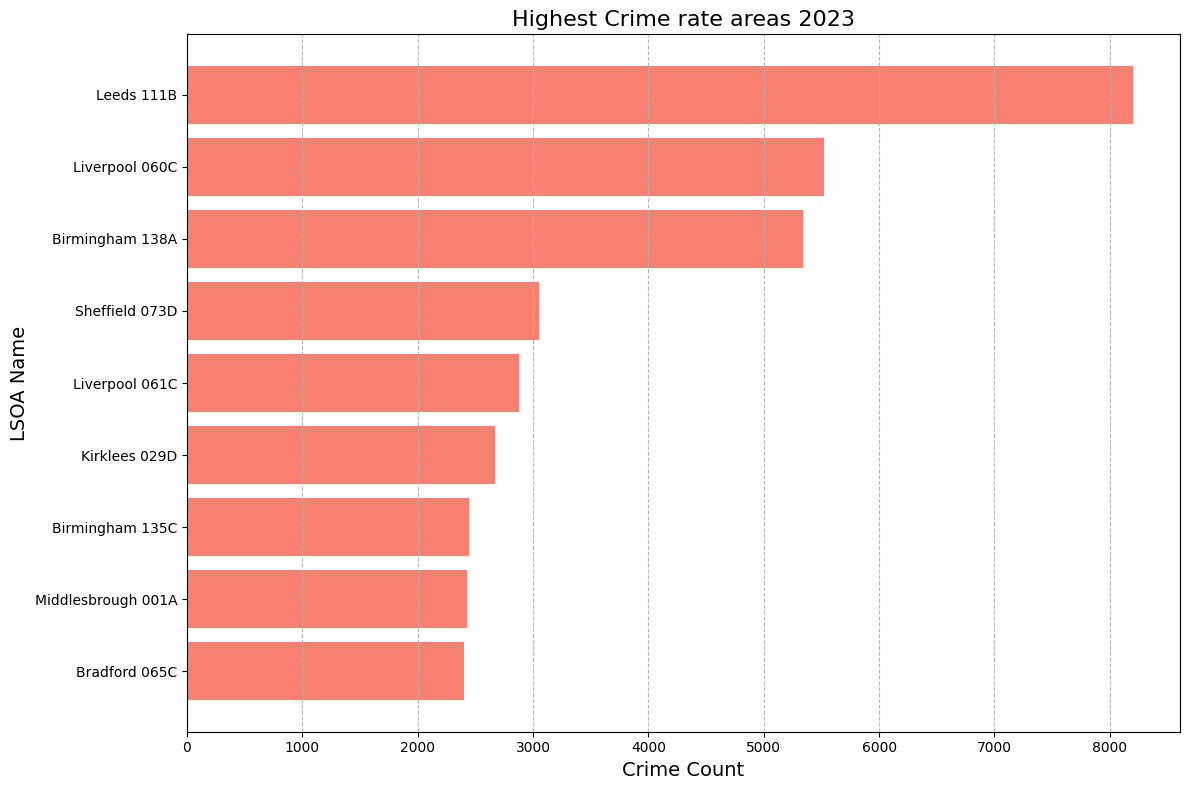

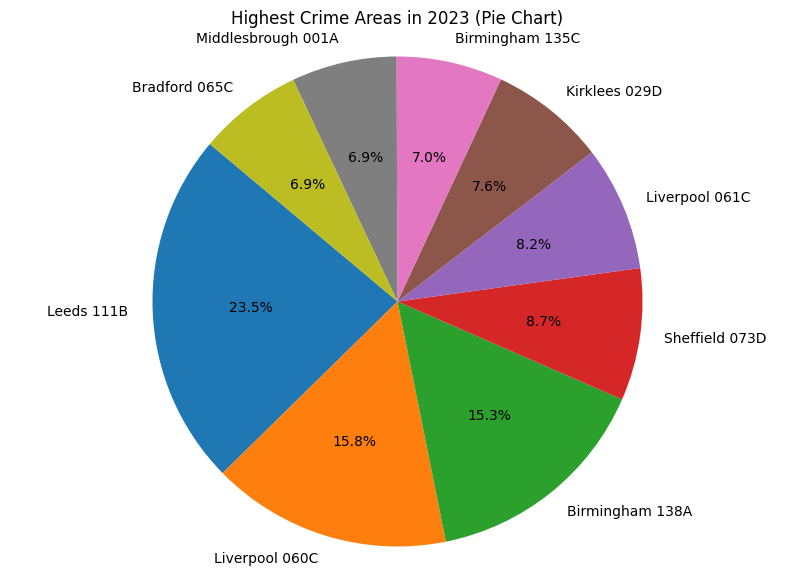

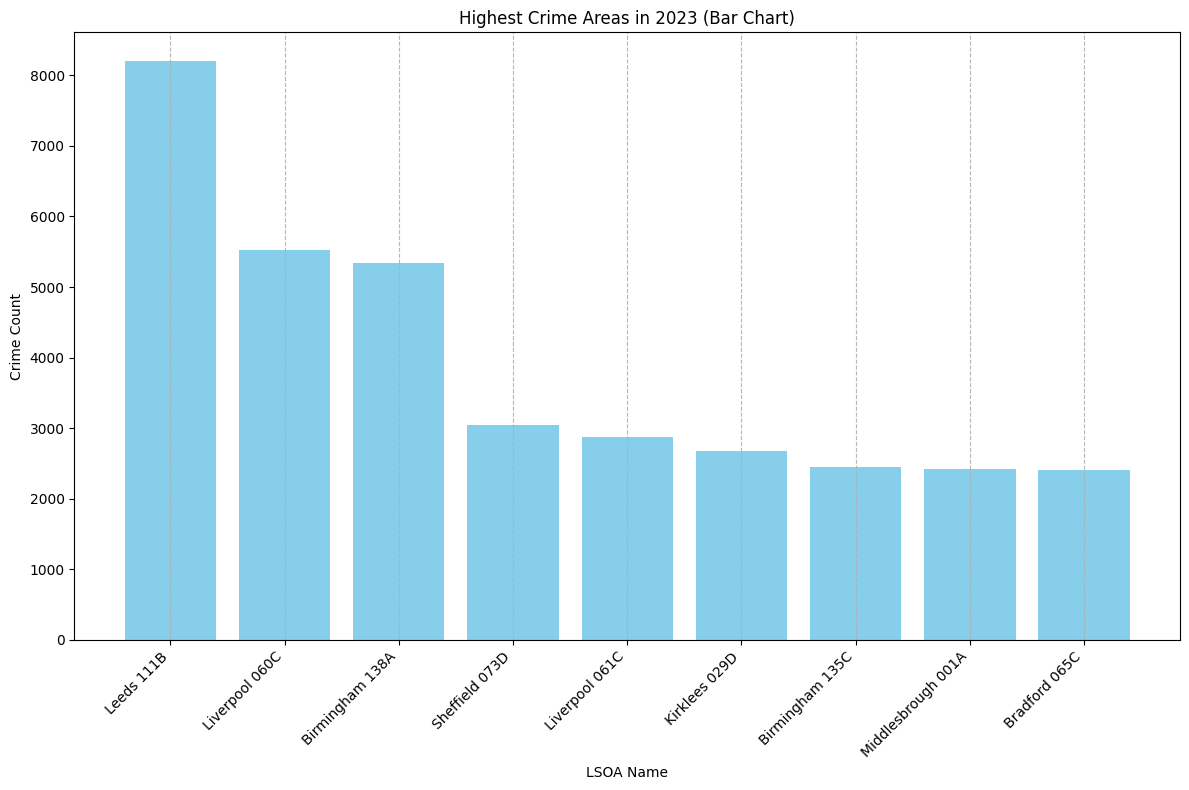

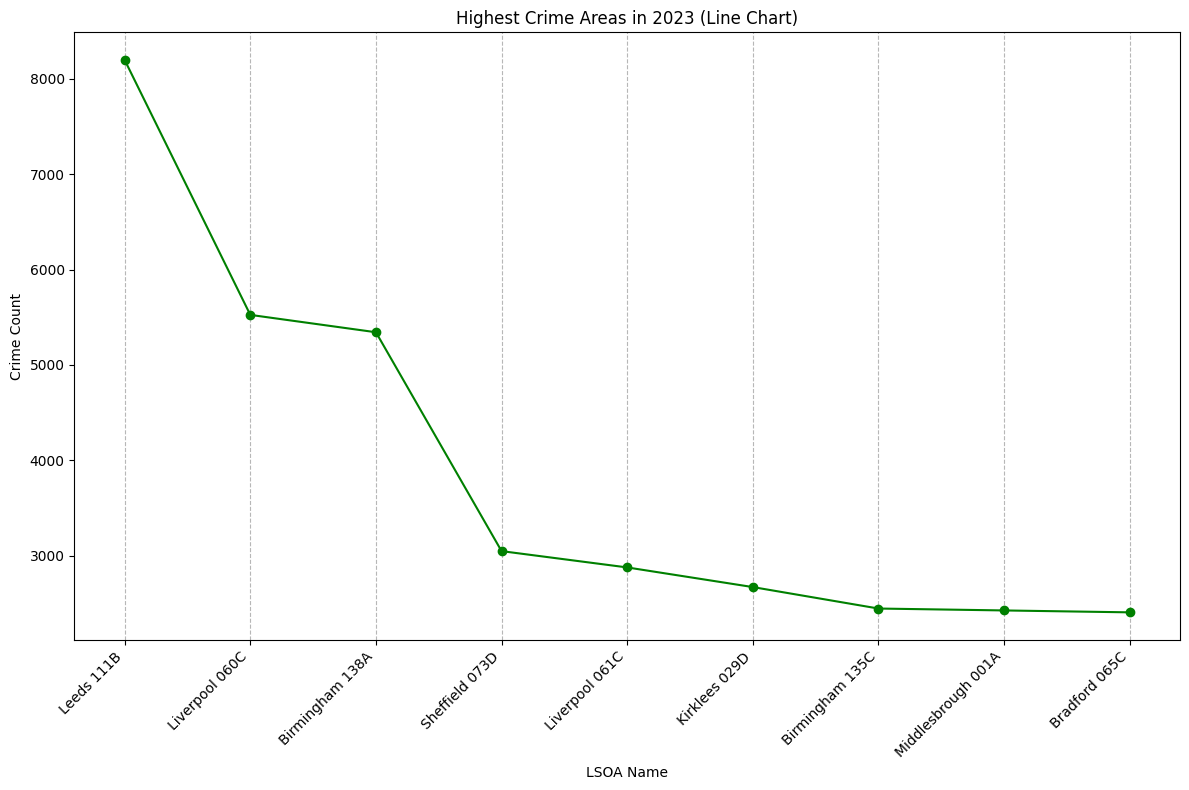

In [45]:
# Example Query 4: Highest crime areas in 2022
highest_crime_rate_areas_2023 = spark.sql("""
    SELECT `LSOA_name`, COUNT(*) AS CrimeCount
    FROM DataCrime_2023
    GROUP BY `LSOA_name`
    ORDER BY CrimeCount DESC
    LIMIT 10
""")
highest_crime_rate_areas_2023.show()

# Data Query: Most common crime types
highest_crime_rate_areas_2023 = spark.sql("""
    SELECT `LSOA_name`, COUNT(*) AS CrimeCount
    FROM Datacrime_2023
    GROUP BY `LSOA_name`
    ORDER BY CrimeCount DESC
    LIMIT 10
""")

# Convert Spark DataFrame to Pandas for visualization
highest_crime_rate_areas_2023_datacrime = highest_crime_rate_areas_2023.toPandas()

# Handle missing values (e.g., drop rows with missing values)
highest_crime_rate_areas_2023_datacrime.dropna(inplace=True)

# Plot Most Common Crime Types
plt.figure(figsize=(12, 8))
plt.barh(highest_crime_rate_areas_2023_datacrime['LSOA_name'], highest_crime_rate_areas_2023_datacrime['CrimeCount'], color='salmon')
plt.title("Highest Crime rate areas 2023", fontsize=16)
plt.xlabel('Crime Count',fontsize=14) 
plt.ylabel('LSOA Name', fontsize=14) 
plt.tight_layout()
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.9)
plt.show()

# Pie chart 
plt.figure(figsize=(10, 7)) 
plt.pie(highest_crime_rate_areas_2023_datacrime['CrimeCount'], labels=highest_crime_rate_areas_2023_datacrime['LSOA_name'], autopct='%1.1f%%', startangle=140) 
plt.title('Highest Crime Areas in 2023 (Pie Chart)') 
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle. 
plt.show()

# Bar chart
plt.figure(figsize=(12, 8))
plt.bar(highest_crime_rate_areas_2023_datacrime['LSOA_name'], highest_crime_rate_areas_2023_datacrime['CrimeCount'], color='skyblue')
plt.title('Highest Crime Areas in 2023 (Bar Chart)')
plt.xlabel('LSOA Name')
plt.ylabel('Crime Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x', linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

# Line chart
plt.figure(figsize=(12, 8))
plt.plot(highest_crime_rate_areas_2023_datacrime['LSOA_name'], highest_crime_rate_areas_2023_datacrime['CrimeCount'], marker='o', linestyle='-', color='green')
plt.title('Highest Crime Areas in 2023 (Line Chart)')
plt.xlabel('LSOA Name')
plt.ylabel('Crime Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x', linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()



+--------------------+----------+
|          Crime_type|CrimeCount|
+--------------------+----------+
|Violence and sexu...|    445346|
|Anti-social behav...|    109485|
|        Public order|    104659|
|Criminal damage a...|     94049|
|       Vehicle crime|     76437|
|         Shoplifting|     75607|
|         Other theft|     73155|
|            Burglary|     57960|
|               Drugs|     35128|
|         Other crime|     25603|
+--------------------+----------+
only showing top 10 rows



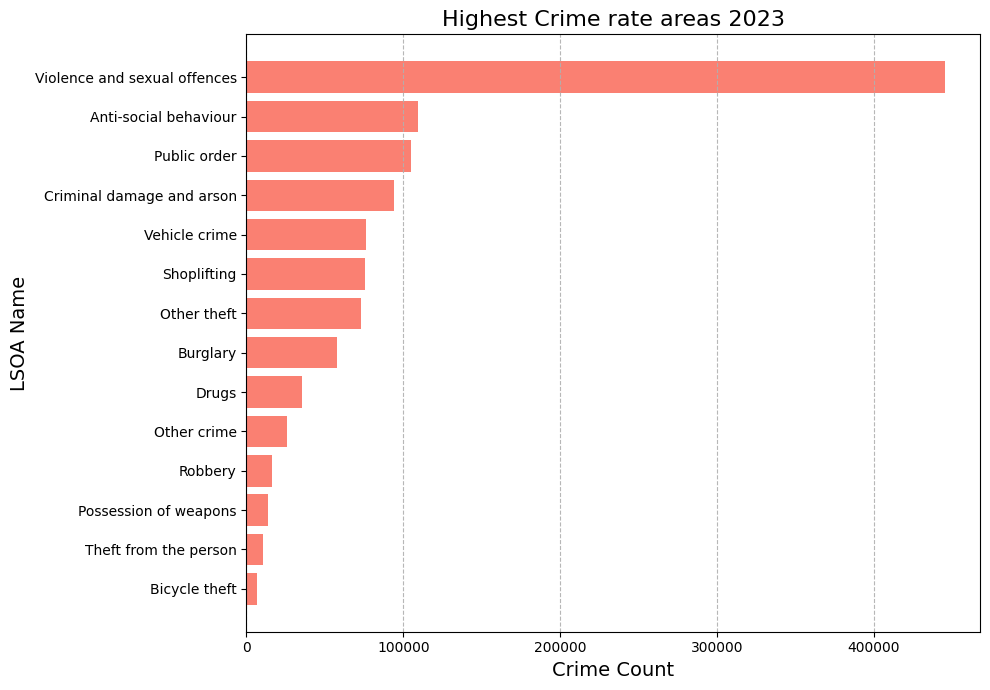

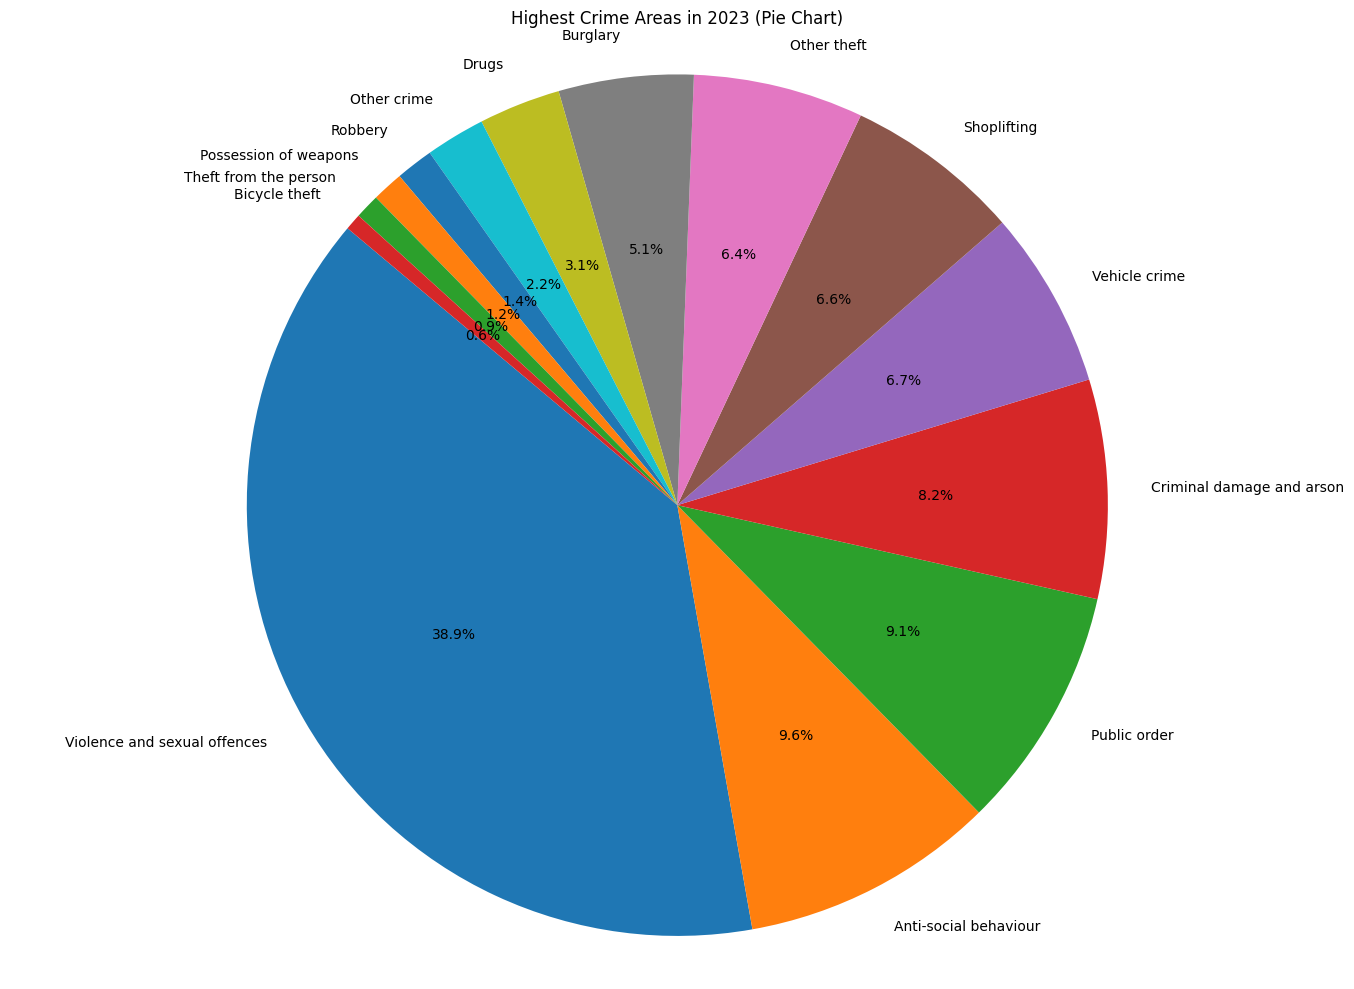

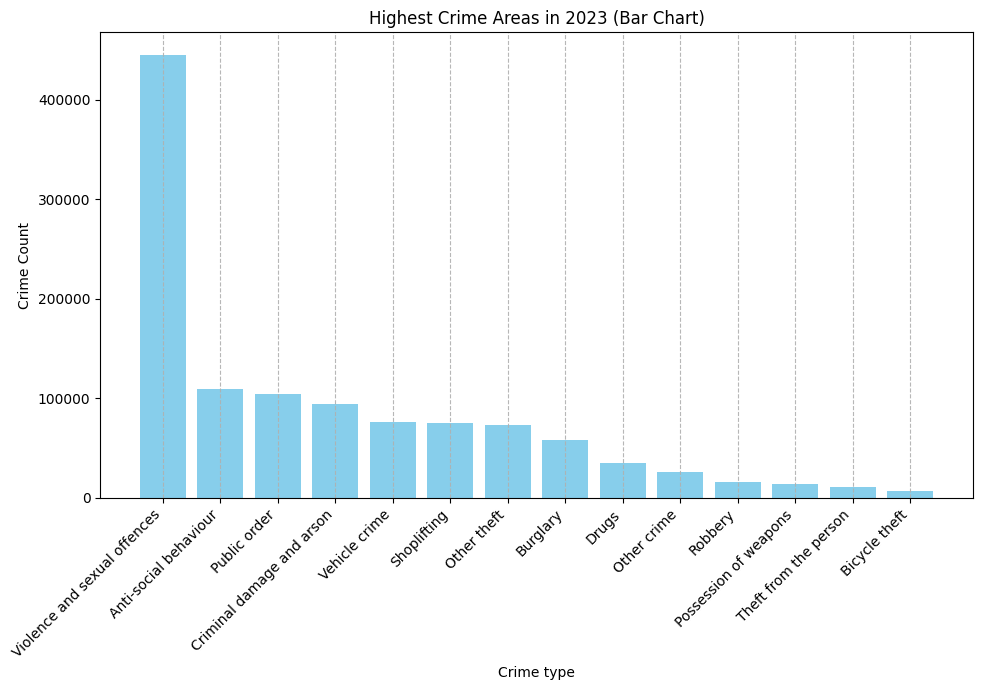

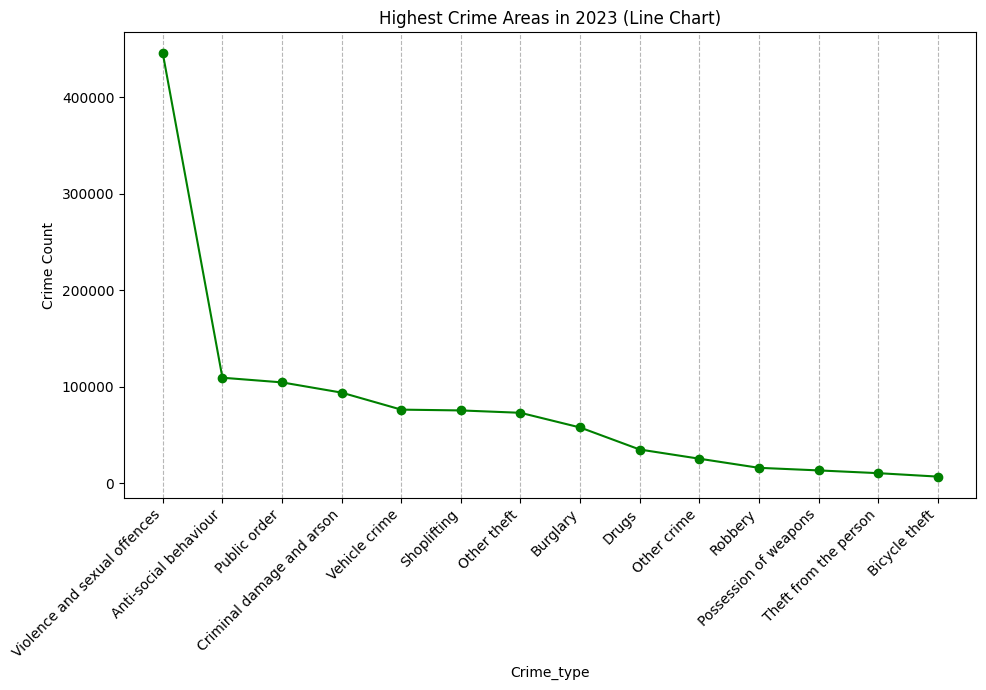

In [46]:
# Example Query 5: Yearly crime rate and type for 2023
yearly_crime_rate_2023 = spark.sql("""
    SELECT `Crime_type`, COUNT(*) AS CrimeCount
    FROM DataCrime_2023
    GROUP BY `Crime_type`
    ORDER BY CrimeCount DESC
""")
yearly_crime_rate_2023.show(10)


# Convert Spark DataFrame to Pandas for visualization
yearly_crime_rate_2023_datacrime = yearly_crime_rate_2023.toPandas()

# Handle missing values (e.g., drop rows with missing values)
yearly_crime_rate_2023_datacrime.dropna(inplace=True)

# Plot Most Common Crime Types
plt.figure(figsize=(10, 7))
plt.barh(yearly_crime_rate_2023_datacrime['Crime_type'], yearly_crime_rate_2023_datacrime['CrimeCount'], color='salmon')
plt.title("Highest Crime rate areas 2023", fontsize=16)
plt.xlabel('Crime Count',fontsize=14) 
plt.ylabel('LSOA Name', fontsize=14) 
plt.tight_layout()
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.9)
plt.show()

# Pie chart 
plt.figure(figsize=(14, 10)) 
plt.pie(yearly_crime_rate_2023_datacrime['CrimeCount'], labels=yearly_crime_rate_2023_datacrime['Crime_type'], autopct='%1.1f%%', startangle=140) 
plt.title('Highest Crime Areas in 2023 (Pie Chart)') 
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle. 
plt.tight_layout()
plt.show()

# Bar chart
plt.figure(figsize=(10, 7))
plt.bar(yearly_crime_rate_2023_datacrime['Crime_type'], yearly_crime_rate_2023_datacrime['CrimeCount'], color='skyblue')
plt.title('Highest Crime Areas in 2023 (Bar Chart)')
plt.xlabel('Crime type')
plt.ylabel('Crime Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x', linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

# Line chart
plt.figure(figsize=(10, 7))
plt.plot(yearly_crime_rate_2023_datacrime['Crime_type'], yearly_crime_rate_2023_datacrime['CrimeCount'], marker='o', linestyle='-', color='green')
plt.title('Highest Crime Areas in 2023 (Line Chart)')
plt.xlabel('Crime_type')
plt.ylabel('Crime Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x', linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()



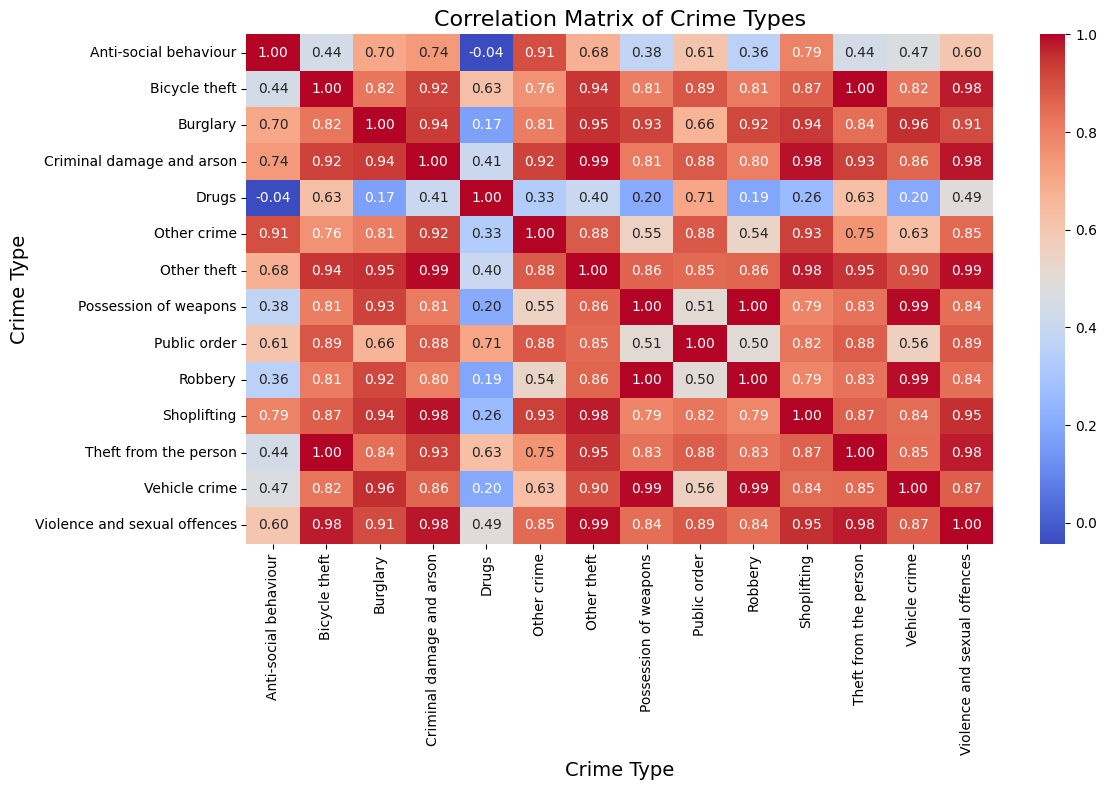

In [47]:
# Register the DataFrame as a SQL temporary view
DataCrime.createOrReplaceTempView("DataCrime")

# Query: Crime counts per city and most common crime type
crime_correlation_data = spark.sql("""
    SELECT `Falls_within` AS City, `Crime_type`, COUNT(*) AS CrimeCount
    FROM DataCrime
    GROUP BY `Falls_within`, `Crime_type`
""")

# Convert Spark DataFrame to Pandas for correlation analysis
crime_correlation_DataCrime = crime_correlation_data.toPandas()

# Create a pivot table to prepare for correlation analysis
crime_correlation_pivot = crime_correlation_DataCrime.pivot_table(
    values='CrimeCount', 
    index='City', 
    columns='Crime_type', 
    fill_value=0
)

# Calculate correlation matrix
correlation_matrix = crime_correlation_pivot.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Crime Types", fontsize=16)
plt.xlabel("Crime Type", fontsize=14)
plt.ylabel("Crime Type", fontsize=14)
plt.tight_layout()
plt.show()


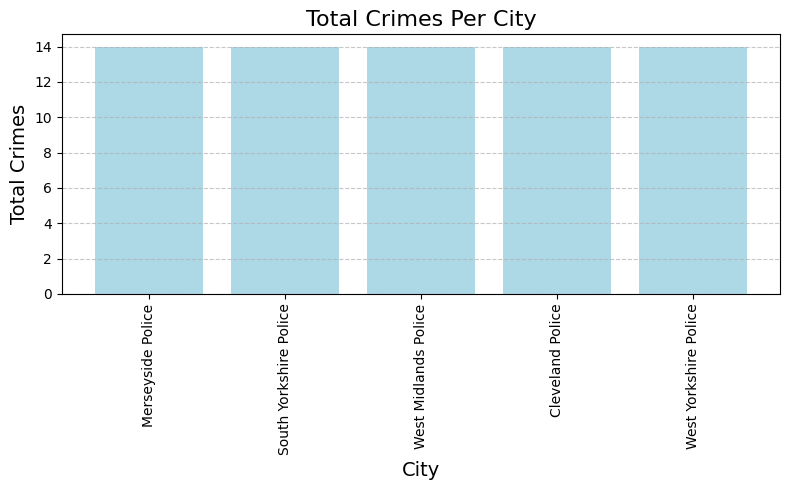

                     City  TotalCrimes     AvgCrimes  CumulativeSum  \
0       Merseyside Police           14  25262.571429             14   
1  South Yorkshire Police           14  26244.000000             28   
2    West Midlands Police           14  53631.142857             42   
3        Cleveland Police           14  13995.714286             56   
4   West Yorkshire Police           14  48238.285714             70   

   CumulativeProduct  
0                 14  
1                196  
2               2744  
3              38416  
4             537824  


In [48]:
# Register the DataFrame as a SQL temporary view
DataCrime.createOrReplaceTempView("DataCrime")

# Aggregation Query: Total crime count and average crimes per city
datacrime_aggregations = spark.sql("""
    SELECT `Falls_within` AS City, 
           COUNT(*) AS TotalCrimes,
           AVG(CrimeCount) AS AvgCrimes
    FROM (
        SELECT `Falls_within`, `Crime_type`, COUNT(*) AS CrimeCount
        FROM DataCrime
        GROUP BY `Falls_within`, `Crime_type`
    )
    GROUP BY City
    ORDER BY TotalCrimes DESC
""")
aggregations_datacrime_df = datacrime_aggregations.toPandas()

# Adding Cumulative Sum and Cumulative Product in Pandas
aggregations_datacrime_df['CumulativeSum'] = aggregations_datacrime_df['TotalCrimes'].cumsum()
aggregations_datacrime_df['CumulativeProduct'] = aggregations_datacrime_df['TotalCrimes'].cumprod()


# Visualizing Aggregations
plt.figure(figsize=(8, 5))
plt.bar(aggregations_datacrime_df['City'], aggregations_datacrime_df['TotalCrimes'], color='lightblue')
plt.title("Total Crimes Per City", fontsize=16)
plt.xlabel("City", fontsize=14)
plt.ylabel("Total Crimes", fontsize=14)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the first few rows of the processed DataFrame
print(aggregations_datacrime_df.head())

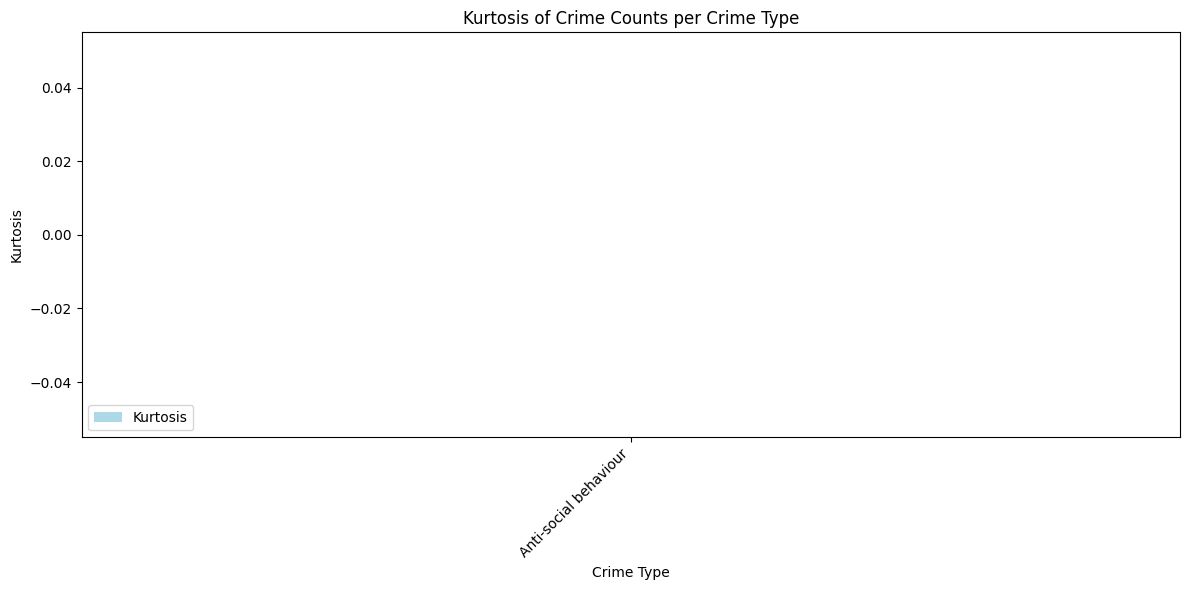

In [49]:
# Register the DataFrame as a SQL temporary view
DataCrime.createOrReplaceTempView("DataCrime")

# Query: Crime counts per crime type
crime_counts_per_type = spark.sql("""
    SELECT `Crime_type` AS CrimeType, COUNT(*) AS CrimeCount
    FROM DataCrime
    GROUP BY `Crime_type`
""")

# Convert Spark DataFrame to Pandas DataFrame for statistical analysis
crime_counts_data = crime_counts_per_type.toPandas()

# Calculate kurtosis for each crime type
kurtosis_values = crime_counts_data.groupby('CrimeType')['CrimeCount'].apply(pd.Series.kurt)

# Plot the kurtosis values
plt.figure(figsize=(12, 6))
plt.bar(kurtosis_values.index, kurtosis_values.values, color='lightblue', label='Kurtosis')
plt.xlabel('Crime Type')
plt.ylabel('Kurtosis')
plt.title('Kurtosis of Crime Counts per Crime Type')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

Skewness of crime counts per city: 0.27315494903961174
Kurtosis of crime counts per city: -2.23423162361955


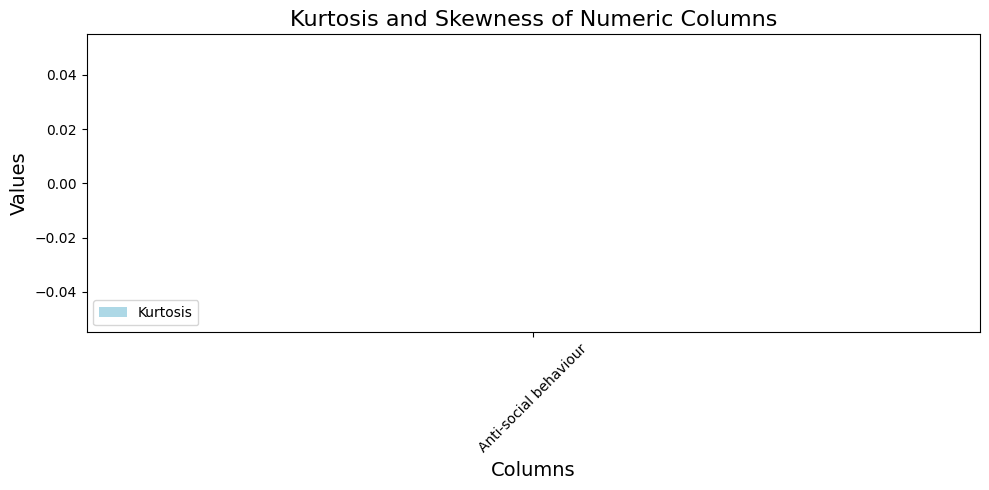

In [50]:
# Register the DataFrame as a SQL temporary view
DataCrime.createOrReplaceTempView("DataCrime")

# Query: Crime counts per city
crime_counts_per_city = spark.sql("""
    SELECT `Falls_within` AS City, COUNT(*) AS CrimeCount
    FROM DataCrime
    GROUP BY `Falls_within`
""")

# Convert Spark DataFrame to Pandas DataFrame for statistical analysis
Datacrime_counts = crime_counts_per_city.toPandas()

# Calculate skewness and kurtosis
skewness = Datacrime_counts['CrimeCount'].skew()
kurtosis = Datacrime_counts['CrimeCount'].kurt()

print(f"Skewness of crime counts per city: {skewness}")
print(f"Kurtosis of crime counts per city: {kurtosis}")


# Visualize skewness and kurtosis
plt.figure(figsize=(10, 5))
plt.bar(kurtosis_values.index, kurtosis_values.values, color='lightblue', label='Kurtosis')
plt.title("Kurtosis and Skewness of Numeric Columns", fontsize=16)
plt.xlabel("Columns", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

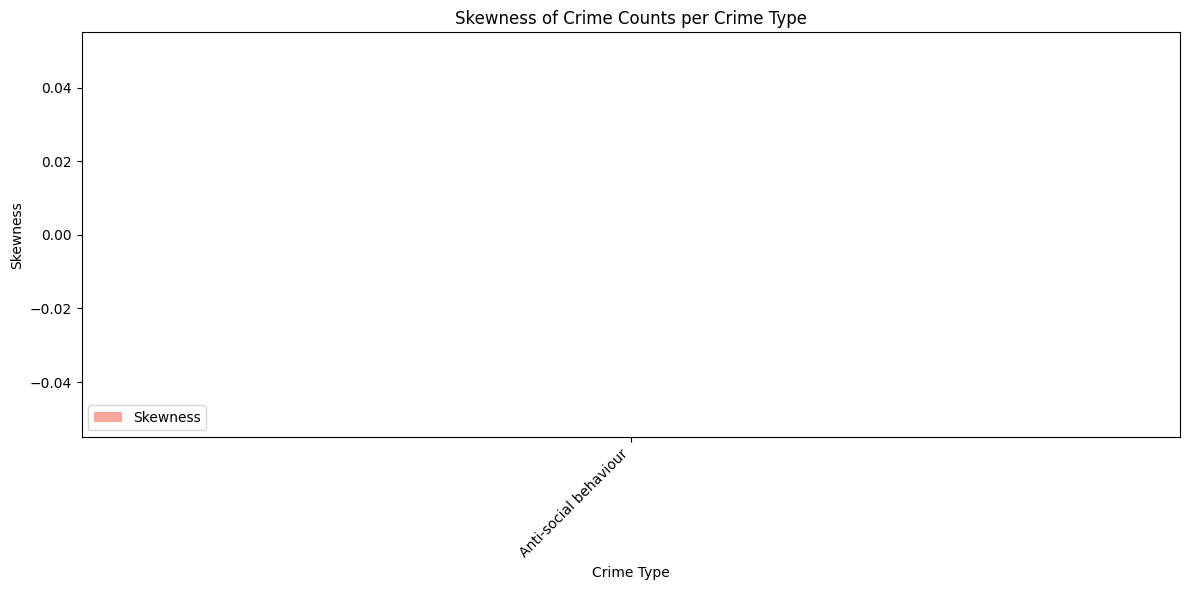

In [51]:
# Register the DataFrame as a SQL temporary view
DataCrime.createOrReplaceTempView("DataCrime")

# Query: Crime counts per crime type
datacrime_counts_per_type = spark.sql("""
    SELECT `Crime_type` AS CrimeType, COUNT(*) AS CrimeCount
    FROM DataCrime
    GROUP BY `Crime_type`
""")

# Convert Spark DataFrame to Pandas DataFrame for statistical analysis
datacrime_crime_counts = datacrime_counts_per_type.toPandas()

# Calculate skewness for each crime type
skewness_values = datacrime_crime_counts.groupby('CrimeType')['CrimeCount'].apply(pd.Series.skew)

# Plot the skewness values
plt.figure(figsize=(12, 6))
plt.bar(skewness_values.index, skewness_values.values, color='salmon', label='Skewness', alpha=0.7)
plt.xlabel('Crime Type')
plt.ylabel('Skewness')
plt.title('Skewness of Crime Counts per Crime Type')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


In [52]:
# Register the DataFrame as a SQL temporary view
#DataCrime.createOrReplaceTempView("DataCrime")

# Convert Spark DataFrame to Pandas DataFrame
#DataCrime = DataCrime.toPandas()

# Calculate covariance matrix
#covariance_matrix = DataCrime.cov()
#print("Covariance Matrix:")
#print(covariance_matrix)

# Plot the covariance matrix
#plt.figure(figsize=(10, 8))
#plt.matshow(covariance_matrix, cmap="coolwarm", fignum=1)
#plt.colorbar()
#plt.title("Covariance Matrix", fontsize=16, pad=30)
#plt.xticks(range(len(covariance_matrix.columns)), covariance_matrix.columns, rotation=90)
#plt.yticks(range(len(covariance_matrix.columns)), covariance_matrix.columns)
#plt.tight_layout()
#plt.show()


In [53]:
# Calculate autocorrelation for a numeric column (e.g., CrimeCount)
if 'CrimeCount' in DataCrime.columns:
    autocorr_values = [DataCrime['CrimeCount'].autocorr(lag) for lag in range(1, 11)]
    print("Autocorrelation Values (CrimeCount):")
    print(autocorr_values)

    # Plot autocorrelation values
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, 11), autocorr_values, color='purple', alpha=0.7)
    plt.title("Autocorrelation for CrimeCount", fontsize=16)
    plt.xlabel("Lag", fontsize=14)
    plt.ylabel("Autocorrelation", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("CrimeCount column is not available in the dataset for autocorrelation analysis.")


CrimeCount column is not available in the dataset for autocorrelation analysis.
